В работе использовались открытые данные приложения к книге _An Introduction to Statistical Learning with Applications in R_ by _Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani_: [Туц](http://www-bcf.usc.edu/~gareth/ISL/data.html).

## Градиентный спуск
Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Stochastic Gradient Descent (SGD)
Проблема градиентного спуска, описанного выше, в том, что на больших выборках считать на каждом шаге градиент по всем имеющимся данным может быть очень вычислительно сложно. 
В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

In [41]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

**Загружаем информацию из файла advertising.csv**

In [50]:
adver_data = pd.read_csv('advertising.csv')
adver_data.pop('N')

0        1
1        2
2        3
3        4
4        5
5        6
6        7
7        8
8        9
9       10
10      11
11      12
12      13
13      14
14      15
15      16
16      17
17      18
18      19
19      20
20      21
21      22
22      23
23      24
24      25
25      26
26      27
27      28
28      29
29      30
      ... 
170    171
171    172
172    173
173    174
174    175
175    176
176    177
177    178
178    179
179    180
180    181
181    182
182    183
183    184
184    185
185    186
186    187
187    188
188    189
189    190
190    191
191    192
192    193
193    194
194    195
195    196
196    197
197    198
198    199
199    200
Name: N, Length: 200, dtype: int64

**Смотрим на первые 5 записей и на статистику признаков в этом наборе данных.**

In [51]:
adver_data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


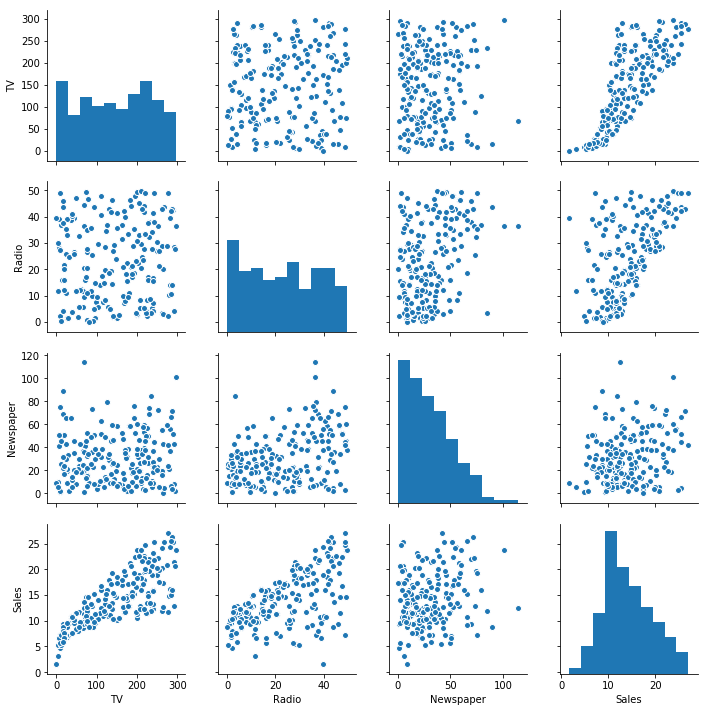

In [52]:
sns.pairplot(adver_data)

**Создаём массивы NumPy *X* из столбцов TV, Radio и Newspaper и *y* - из столбца Sales.**

In [53]:
X = adver_data[['TV', 'Radio', 'Newspaper']]
y = adver_data.Sales

**Масштабируем столбцы матрицы X, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [54]:
# арифметическое среднее
means = X.apply(np.mean)

# стандартное отклонение
stds = X.apply(np.std)

In [55]:
X = X.apply(lambda x: (x - means) / stds, axis = 1)

In [56]:
X.apply(np.mean)
X.apply(np.std)

TV           1.0
Radio        1.0
Newspaper    1.0
dtype: float64

**Добавляем столбец из единиц, дабы не обрабатывать коэффициент линейной регрессии отдельно**

In [57]:
X['x0'] = 1
X = X[['x0', 'TV', 'Radio', 'Newspaper']]
X.head()

,x0,TV,Radio,Newspaper
0,1,0.969852,0.981522,1.778945
1,1,-1.197376,1.082808,0.669579
2,1,-1.516155,1.528463,1.783549
3,1,0.052050,1.217855,1.286405
4,1,0.394182,-0.841614,1.281802


**Реализуем функцию *mserror* - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series *y* (значения целевого признака) и *y\_pred* (предсказанные значения).**

**Не используем в этой функции циклы - тогда она будет вычислительно неэффективной.**

Функция: $\dfrac{(y - y_{mean})^{2}}{n}$, где $n$ - количество координат вектора

In [58]:
def mserror(y, y_pred):
    return sum(list(map(lambda x1, x2: (x1 - x2) ** 2, y, y_pred))) / len(y)

**Написали функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.**

In [59]:
def linear_prediction(X, w):
    return X.apply(lambda x: np.dot(x, w), axis=1) 

**Написали функцию *stochastic_gradient_step*, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция принимает матрицу *X*, вектора *y* и *w*, число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов, а также число *$\eta$* (eta) - шаг градиентного спуска (по умолчанию *eta*=0.01). Результат - вектор обновленных весов.**

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$

In [60]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    l = len(y)
    x_k = X.values[train_ind]
    y_k = y.values[train_ind]
    
    return w - 2*eta/l*x_k*(np.dot(w, x_k) - y_k)

**Написали функцию *stochastic_gradient_descent*, реализующую стохастический градиентный спуск для линейной регрессии.
Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

**На каждой итерации в вектор (список) записывается текущее значение среднеквадратичной ошибки. Функция возвращает вектор весов $w$, а также вектор (список) ошибок.**

In [61]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        # обновление весов
        new_w = stochastic_gradient_step(X, y, w, random_ind, eta)
        
        iter_num+=1
        weight_dist = np.linalg.norm(new_w - w)
        
        errors.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    print(weight_dist)
    return w, errors

 **Запустили $10^5$ итераций стохастического градиентного спуска. Указали вектор начальных весов *w_init*, состоящий из нулей. Оставили параметры  *eta* и *seed* равными их значениям по умолчанию (*eta*=0.01, *seed*=42).**
 
 Запустили таймер.

In [62]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, np.zeros(4), max_iter = 1e5)
print(stoch_grad_desc_weights)

5.0536343368235184e-09
[ 1.40190566e+01  3.91069256e+00  2.78209808e+00 -8.10462217e-03]
CPU times: user 5min 18s, sys: 181 ms, total: 5min 18s
Wall time: 5min 18s


**Построили график ошибки на последних 50 итерациях стохастического градиентного спуска. Видим, что ошибка не обязательно уменьшается на каждой итерации.**

*MSE - mean square error

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

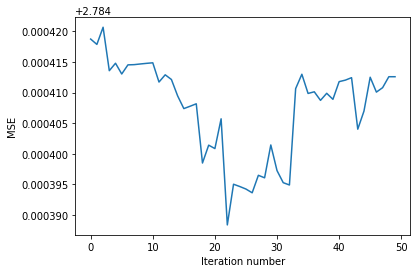

In [63]:
%pylab inline
plot(range(50), stoch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

**Построили график зависимости ошибки от номера итерации для $10^4$ итераций стохастического градиентного спуска. Видим, что алгоритм сходится.**

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

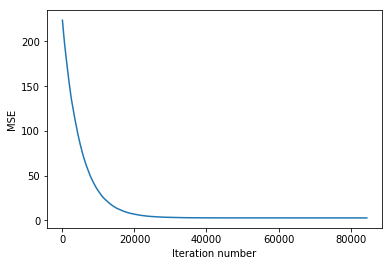

In [64]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Цикличный mini-batch

In [65]:
def mini_batch_step(X, y, w, train_ind, random_ind, eta=0.01):
    l = len(y)
    x_k = [0.0] * train_ind
    y_k = [0.0] * train_ind
    
    for i in range(train_ind - 1):
        x_k[i] = X.values[random_ind[i]]
        y_k[i] = y.values[random_ind[i]]
    
    ans = 0
    for i in range(train_ind - 1):
        ans += 2*eta/l*x_k[i]*(y_k[i] - np.dot(w, x_k[i]))
    
    return w + ans

In [66]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_step(X, y, w, batch_size, random_ind)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        print(weight_dist, min_weight_dist)
        print(iter_num)
        print('\n')
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [67]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)

0.012030968213711525 1e-08
1


0.011127129587986478 1e-08
2


0.016851284829776828 1e-08
3


0.024628254781668128 1e-08
4


0.014172546475151957 1e-08
5


0.014349291479228391 1e-08
6


0.011518358119656597 1e-08
7


0.021117116782545412 1e-08
8


0.01384062299273516 1e-08
9


0.015034018156011296 1e-08
10


0.013805364729800129 1e-08
11


0.013081182683855153 1e-08
12


0.011729234947434415 1e-08
13


0.021799007352454654 1e-08
14


0.01911554497367456 1e-08
15


0.013107653546977278 1e-08
16


0.013478770295815666 1e-08
17


0.011017219432845964 1e-08
18


0.017398521888303525 1e-08
19


0.01928175410785765 1e-08
20


0.02662915794515777 1e-08
21


0.01981549575825461 1e-08
22


0.011645524812565124 1e-08
23


0.011603538173973721 1e-08
24


0.015340267458488151 1e-08
25


0.012280034235758843 1e-08
26


0.021243694229812638 1e-08
27


0.018539637850239092 1e-08
28


0.011718434758899578 1e-08
29


0.01265372267130523 1e-08
30


0.011814218955815258 1e-08
31


0.011248760673867061 1e

0.01588714351429215 1e-08
270


0.014366837205346067 1e-08
271


0.007077516676888843 1e-08
272


0.010621815157564366 1e-08
273


0.008356748516522749 1e-08
274


0.00962042179583907 1e-08
275


0.00895688660231357 1e-08
276


0.010944449636721152 1e-08
277


0.01109402047628066 1e-08
278


0.013667866960493116 1e-08
279


0.010549366874354885 1e-08
280


0.008632552865564464 1e-08
281


0.009521855235037931 1e-08
282


0.012843395332070127 1e-08
283


0.00950074119351028 1e-08
284


0.013664158420470817 1e-08
285


0.008729795399969138 1e-08
286


0.012189580676820919 1e-08
287


0.009062147668887134 1e-08
288


0.008909951552149993 1e-08
289


0.010139684607222543 1e-08
290


0.007771022020320701 1e-08
291


0.010519730183194369 1e-08
292


0.014736169746165319 1e-08
293


0.01132250924672968 1e-08
294


0.012463709030976216 1e-08
295


0.01135692027845238 1e-08
296


0.009991466427372952 1e-08
297


0.012024438459824592 1e-08
298


0.014434774436230452 1e-08
299


0.009680584979289

0.009917769901612207 1e-08
528


0.008635590777265424 1e-08
529


0.009246194071204122 1e-08
530


0.008995554267582516 1e-08
531


0.0066939265076147916 1e-08
532


0.012331078957728942 1e-08
533


0.008260193492308842 1e-08
534


0.011170580450727023 1e-08
535


0.013630341583221873 1e-08
536


0.010606514225363104 1e-08
537


0.00772812788662793 1e-08
538


0.008288345982477963 1e-08
539


0.01228703738807576 1e-08
540


0.008693594238247102 1e-08
541


0.00892236600713773 1e-08
542


0.010026173078547449 1e-08
543


0.007713166388965442 1e-08
544


0.010406575302272106 1e-08
545


0.008079961008042959 1e-08
546


0.013109132504438105 1e-08
547


0.009573295059720818 1e-08
548


0.008824359355542747 1e-08
549


0.00858722533233495 1e-08
550


0.009900441301374947 1e-08
551


0.006983009587539743 1e-08
552


0.010494919575485737 1e-08
553


0.00827258694209515 1e-08
554


0.012132027226437407 1e-08
555


0.00773355905431024 1e-08
556


0.008709796202901656 1e-08
557


0.0072968858231

0.005367508234209005 1e-08
794


0.005165175370426006 1e-08
795


0.008309711757456744 1e-08
796


0.008813874957350696 1e-08
797


0.006306967066358137 1e-08
798


0.006306083765057587 1e-08
799


0.006215461207958299 1e-08
800


0.007228790159765791 1e-08
801


0.007915263643224297 1e-08
802


0.006679675053648749 1e-08
803


0.009133377945113463 1e-08
804


0.008734394734912285 1e-08
805


0.005309277903306004 1e-08
806


0.009575576507663061 1e-08
807


0.008572255538470797 1e-08
808


0.007333598364350694 1e-08
809


0.007137485495645597 1e-08
810


0.004869488806728458 1e-08
811


0.00573603605265488 1e-08
812


0.005874618290141145 1e-08
813


0.006989057153841772 1e-08
814


0.005369101927806607 1e-08
815


0.009126700790332508 1e-08
816


0.0061056744022864 1e-08
817


0.009580913091405007 1e-08
818


0.006716734324801554 1e-08
819


0.0067720532912004085 1e-08
820


0.007659039898765708 1e-08
821


0.008527952318029249 1e-08
822


0.007419267502597597 1e-08
823


0.0067719124

0.004829933033470847 1e-08
1068


0.004969185616035863 1e-08
1069


0.0042648688449894705 1e-08
1070


0.0048238140632418875 1e-08
1071


0.006133414267931741 1e-08
1072


0.005085191836737186 1e-08
1073


0.006514955163032738 1e-08
1074


0.004687103171624572 1e-08
1075


0.005771975477777288 1e-08
1076


0.004270686739246892 1e-08
1077


0.005560884974770045 1e-08
1078


0.005509393444311228 1e-08
1079


0.004928717632732298 1e-08
1080


0.0052812449970583535 1e-08
1081


0.006605594312237205 1e-08
1082


0.004418417375802259 1e-08
1083


0.0059329267361068055 1e-08
1084


0.0056593004436490705 1e-08
1085


0.005646845372255287 1e-08
1086


0.0047028251569902505 1e-08
1087


0.007761862728778268 1e-08
1088


0.006441189862689029 1e-08
1089


0.0033303941032164705 1e-08
1090


0.006580573318205312 1e-08
1091


0.00504843551116299 1e-08
1092


0.003980301986758215 1e-08
1093


0.005595108412271754 1e-08
1094


0.005438216225815457 1e-08
1095


0.0055078211919778065 1e-08
1096


0.00418

0.005836731365641994 1e-08
1346


0.0037522179016206453 1e-08
1347


0.0048852958832270345 1e-08
1348


0.004469518368564817 1e-08
1349


0.0044471287280924065 1e-08
1350


0.005429089072042253 1e-08
1351


0.0045020138160047785 1e-08
1352


0.007088957847219638 1e-08
1353


0.003691526172618157 1e-08
1354


0.003101751019748352 1e-08
1355


0.004809700713692748 1e-08
1356


0.00440320098758194 1e-08
1357


0.00452529441344286 1e-08
1358


0.003948417131701088 1e-08
1359


0.003969495974532052 1e-08
1360


0.003200283172984146 1e-08
1361


0.004487164685828529 1e-08
1362


0.0054713629865293725 1e-08
1363


0.0054636279377870125 1e-08
1364


0.0034170713532153236 1e-08
1365


0.0036021506081565023 1e-08
1366


0.003589323551665612 1e-08
1367


0.004632217739537346 1e-08
1368


0.00399568057407064 1e-08
1369


0.004708025885729369 1e-08
1370


0.002774427059743185 1e-08
1371


0.00321624067510879 1e-08
1372


0.005713940469699766 1e-08
1373


0.005245109653095106 1e-08
1374


0.00447578

0.002921116711829557 1e-08
1613


0.003858540121526614 1e-08
1614


0.002364475391296929 1e-08
1615


0.0031522521216787685 1e-08
1616


0.003920568676155073 1e-08
1617


0.0028766969421151487 1e-08
1618


0.0042447081199114955 1e-08
1619


0.0020912923531381886 1e-08
1620


0.0026081596548337247 1e-08
1621


0.004963547704310067 1e-08
1622


0.0030527344498168046 1e-08
1623


0.004432001446614034 1e-08
1624


0.00485690772101763 1e-08
1625


0.0036367478305219217 1e-08
1626


0.004118827809727355 1e-08
1627


0.0031819249601266176 1e-08
1628


0.004037645862666169 1e-08
1629


0.0033384732483444607 1e-08
1630


0.004163082067335243 1e-08
1631


0.0034043358983183404 1e-08
1632


0.003017741216295659 1e-08
1633


0.003353447005754283 1e-08
1634


0.0030751784414238858 1e-08
1635


0.003451582670872595 1e-08
1636


0.0036775184114881403 1e-08
1637


0.004802740319327837 1e-08
1638


0.002289330473076907 1e-08
1639


0.0037799750930355407 1e-08
1640


0.0038179669753426546 1e-08
1641


0

0.0019005238755235416 1e-08
1869


0.003061561487958239 1e-08
1870


0.0028267226152164037 1e-08
1871


0.0032558816805313986 1e-08
1872


0.0019377431371806566 1e-08
1873


0.0023774331765833265 1e-08
1874


0.0029961428675536732 1e-08
1875


0.0045162654425572515 1e-08
1876


0.002985192030321737 1e-08
1877


0.0029601578144450038 1e-08
1878


0.0029151545024721664 1e-08
1879


0.0030361047804191464 1e-08
1880


0.0030712416246426607 1e-08
1881


0.0027716176394404638 1e-08
1882


0.004056117167813868 1e-08
1883


0.002897576009251792 1e-08
1884


0.0023771420793342792 1e-08
1885


0.0019065710459114605 1e-08
1886


0.003553292378090379 1e-08
1887


0.004353730337668922 1e-08
1888


0.0031816723164659467 1e-08
1889


0.0022628919195243945 1e-08
1890


0.003290592488385504 1e-08
1891


0.001966722764618294 1e-08
1892


0.0047668058645794235 1e-08
1893


0.0024214258909028633 1e-08
1894


0.0033287402064075934 1e-08
1895


0.002090039529504559 1e-08
1896


0.002858775145087092 1e-08
18

0.0014934746720698764 1e-08
2134


0.0017298496785611741 1e-08
2135


0.0033091178237969576 1e-08
2136


0.0020874987865139353 1e-08
2137


0.0034560882044893876 1e-08
2138


0.0025025795057182793 1e-08
2139


0.0019961711607625874 1e-08
2140


0.0018890062665712687 1e-08
2141


0.0015232686480397 1e-08
2142


0.0022547644627595475 1e-08
2143


0.0021014654899188497 1e-08
2144


0.002512381911507265 1e-08
2145


0.002690051400876306 1e-08
2146


0.002009452218959207 1e-08
2147


0.0015643122535408227 1e-08
2148


0.002813378555149746 1e-08
2149


0.004140561073755738 1e-08
2150


0.002287511698734999 1e-08
2151


0.0016818906314531256 1e-08
2152


0.0017800453267167453 1e-08
2153


0.0016579911941600866 1e-08
2154


0.0013146431461775164 1e-08
2155


0.003428299260800471 1e-08
2156


0.0025254687863062327 1e-08
2157


0.001717290275652147 1e-08
2158


0.001303824795791406 1e-08
2159


0.0037003635260923133 1e-08
2160


0.0028045009378136984 1e-08
2161


0.0024922403115569935 1e-08
2162

0.0024643746799173295 1e-08
2398


0.0020551875061836132 1e-08
2399


0.0024357217627654425 1e-08
2400


0.0024584230876347262 1e-08
2401


0.0025050412641256484 1e-08
2402


0.0028118382393600167 1e-08
2403


0.0025277446345687783 1e-08
2404


0.0018077671598316285 1e-08
2405


0.001636669588608195 1e-08
2406


0.0011407464144894354 1e-08
2407


0.001857251712545192 1e-08
2408


0.0011035948428204736 1e-08
2409


0.003455953781843816 1e-08
2410


0.0012002628236741331 1e-08
2411


0.00181616415991553 1e-08
2412


0.0016650401585858424 1e-08
2413


0.0015916404413963473 1e-08
2414


0.002560929030680601 1e-08
2415


0.0019534228381876168 1e-08
2416


0.0020703443054993485 1e-08
2417


0.0019555595312677546 1e-08
2418


0.0012729467703319396 1e-08
2419


0.00248217238241619 1e-08
2420


0.0017307248061059644 1e-08
2421


0.002296227932470849 1e-08
2422


0.0016653353552563831 1e-08
2423


0.0008496790089251615 1e-08
2424


0.0026090354141874105 1e-08
2425


0.0030432218491513955 1e-08
2

0.002314258708198228 1e-08
2647


0.002566470932043412 1e-08
2648


0.0009834949316129052 1e-08
2649


0.0013078078176074997 1e-08
2650


0.002244537412721921 1e-08
2651


0.0024003495053240014 1e-08
2652


0.00139268829242817 1e-08
2653


0.0014409039144852843 1e-08
2654


0.0026245312271817806 1e-08
2655


0.0033824443613095483 1e-08
2656


0.0011437091154705115 1e-08
2657


0.0015764569680126435 1e-08
2658


0.0016464169799148673 1e-08
2659


0.0023830785805618853 1e-08
2660


0.002072343101056473 1e-08
2661


0.0010559318153893292 1e-08
2662


0.0017297315374097475 1e-08
2663


0.0006624389612166061 1e-08
2664


0.001431542312951406 1e-08
2665


0.0018335768338147188 1e-08
2666


0.0027034564517743865 1e-08
2667


0.0014149916773986153 1e-08
2668


0.0013956112108308443 1e-08
2669


0.0016992244841332678 1e-08
2670


0.0014720968562765577 1e-08
2671


0.0023728147570232804 1e-08
2672


0.0016033209901019695 1e-08
2673


0.002599395625913305 1e-08
2674


0.0015167092625577043 1e-08




0.0019063481784135983 1e-08
2897


0.001966375072701498 1e-08
2898


0.0023793988267728373 1e-08
2899


0.001744184854566305 1e-08
2900


0.0016996489605351894 1e-08
2901


0.0014036161841234143 1e-08
2902


0.0011257169459098558 1e-08
2903


0.0011778234881711692 1e-08
2904


0.0014130785776556092 1e-08
2905


0.0010830169036784062 1e-08
2906


0.0011132936307847834 1e-08
2907


0.0023575847638431934 1e-08
2908


0.002370356621922059 1e-08
2909


0.0012962890278710969 1e-08
2910


0.0009071505802668944 1e-08
2911


0.0020123659208662855 1e-08
2912


0.0008632577218821479 1e-08
2913


0.001947701592395637 1e-08
2914


0.0018523269828475098 1e-08
2915


0.0009817387994108912 1e-08
2916


0.0011274095245684954 1e-08
2917


0.002657773361895838 1e-08
2918


0.0015135664899313904 1e-08
2919


0.0008307349478353867 1e-08
2920


0.0010908156631344746 1e-08
2921


0.0014578009327622283 1e-08
2922


0.0015303610394691062 1e-08
2923


0.0016909163099836978 1e-08
2924


0.001418176977722497 1e

0.0015440952454734956 1e-08
3143


0.0031013643642265804 1e-08
3144


0.0012288578852923664 1e-08
3145


0.0015829277612723859 1e-08
3146


0.00169468031707956 1e-08
3147


0.002354870126584996 1e-08
3148


0.00206692882241158 1e-08
3149


0.0007959022058107855 1e-08
3150


0.00041416229674308847 1e-08
3151


0.001257622598948391 1e-08
3152


0.0013198315529459497 1e-08
3153


0.0011915586271857936 1e-08
3154


0.0019465794829514468 1e-08
3155


0.0019856750695910834 1e-08
3156


0.0013972145045705927 1e-08
3157


0.0019463124417508336 1e-08
3158


0.0009058466799477047 1e-08
3159


0.0011613784943759196 1e-08
3160


0.0011687235747404998 1e-08
3161


0.0015753770694737436 1e-08
3162


0.001646809524955254 1e-08
3163


0.0016082398247302535 1e-08
3164


0.0011777661002276866 1e-08
3165


0.0009176273079755659 1e-08
3166


0.0009303995037754913 1e-08
3167


0.0013102534315631107 1e-08
3168


0.0012075214773274935 1e-08
3169


0.0008298077184805023 1e-08
3170


0.0015687553766905121 1e-0

3395


0.001507187077783232 1e-08
3396


0.0015389808122208684 1e-08
3397


0.000922677597820676 1e-08
3398


0.0007303074666209174 1e-08
3399


0.0023624324002881887 1e-08
3400


0.0007665053685315871 1e-08
3401


0.0012595479628662643 1e-08
3402


0.0016356067833875054 1e-08
3403


0.0010964739386249223 1e-08
3404


0.0014430824216854882 1e-08
3405


0.0005304951199021023 1e-08
3406


0.0013785332557965009 1e-08
3407


0.0008575465324077102 1e-08
3408


0.001057241460551843 1e-08
3409


0.0029943878553275708 1e-08
3410


0.0015872492624644716 1e-08
3411


0.0008961294458524182 1e-08
3412


0.002465358569754039 1e-08
3413


0.0012237195002120364 1e-08
3414


0.0020925263270814955 1e-08
3415


0.00200785212324498 1e-08
3416


0.0009386324326941098 1e-08
3417


0.0008058895440466463 1e-08
3418


0.001625468082279035 1e-08
3419


0.0009600151105111061 1e-08
3420


0.0012041308575777162 1e-08
3421


0.0013452806456732116 1e-08
3422


0.002047280524820706 1e-08
3423


0.0008206051277533141

0.000905948082662838 1e-08
3686


0.000799655277925913 1e-08
3687


0.002966633707034309 1e-08
3688


0.0015770575490955895 1e-08
3689


0.00154098393265844 1e-08
3690


0.0016444447889797957 1e-08
3691


0.00036099809034874353 1e-08
3692


0.0008552321904330276 1e-08
3693


0.00204904856073191 1e-08
3694


0.0012321835885689867 1e-08
3695


0.0010592490144954259 1e-08
3696


0.0012250489901476805 1e-08
3697


0.0021840204634849514 1e-08
3698


0.0010423389341301628 1e-08
3699


0.0013663477158150316 1e-08
3700


0.0011488629128247054 1e-08
3701


0.0016601101246721845 1e-08
3702


0.0007132259578636773 1e-08
3703


0.0014101792243884418 1e-08
3704


0.0008584035546958422 1e-08
3705


0.0007068110138097359 1e-08
3706


0.0010042749214852255 1e-08
3707


0.0013778558872767363 1e-08
3708


0.001061163147258097 1e-08
3709


0.0013812060320426772 1e-08
3710


0.0006619763042627464 1e-08
3711


0.0012937612119471031 1e-08
3712


0.0008172533250492712 1e-08
3713


0.001643815424601682 1e-08


0.001128180868136011 1e-08
3944


0.0007366477658399083 1e-08
3945


0.0018592915434509567 1e-08
3946


0.0008892690545326382 1e-08
3947


0.0013075848911701916 1e-08
3948


0.0011893567838727058 1e-08
3949


0.002259981110311267 1e-08
3950


0.0013988832201875638 1e-08
3951


0.0013402132405599646 1e-08
3952


0.0011352784797480106 1e-08
3953


0.000689753891626049 1e-08
3954


0.0006956677140626115 1e-08
3955


0.0013951815131769533 1e-08
3956


0.0014586270666361561 1e-08
3957


0.0017060957709579226 1e-08
3958


0.0010674371806187156 1e-08
3959


0.00024033451312933517 1e-08
3960


0.0008342478301440728 1e-08
3961


0.001070535687563028 1e-08
3962


0.0013068668947845824 1e-08
3963


0.0031132311681517453 1e-08
3964


0.0011403395543009933 1e-08
3965


0.001883624879065078 1e-08
3966


0.0013152276117634261 1e-08
3967


0.00031772766158018437 1e-08
3968


0.001699778637646053 1e-08
3969


0.0012515514906652685 1e-08
3970


0.0004679900631327471 1e-08
3971


0.002026872017416836 1e-

0.0012717642368820854 1e-08
4186


0.000862838520433301 1e-08
4187


0.0011305321307922055 1e-08
4188


0.0006460959436832079 1e-08
4189


0.0006744691454572324 1e-08
4190


0.0011525543827628955 1e-08
4191


0.0006412257989501759 1e-08
4192


0.0009307003143856784 1e-08
4193


0.0010286010045727854 1e-08
4194


0.00044101091199877715 1e-08
4195


0.0006974204645101606 1e-08
4196


0.0007287460431593222 1e-08
4197


0.0006479602762407392 1e-08
4198


0.0005932488068173156 1e-08
4199


0.00045042763502844334 1e-08
4200


0.0019415742663005573 1e-08
4201


0.0015078309343389525 1e-08
4202


0.0007249257367929278 1e-08
4203


0.0007234476237997082 1e-08
4204


0.0007139384911834573 1e-08
4205


0.0012805073655123601 1e-08
4206


0.0011186280564084725 1e-08
4207


0.0016337197762966208 1e-08
4208


0.001463026374633794 1e-08
4209


0.0011417637653307103 1e-08
4210


0.0009291401251786895 1e-08
4211


0.0016887523175675202 1e-08
4212


0.001164111966114653 1e-08
4213


0.0014446127972619462

0.0007021712944072075 1e-08
4446


0.0008319968601136989 1e-08
4447


0.0012315160727812524 1e-08
4448


0.0011269737813921067 1e-08
4449


0.0011356304750826318 1e-08
4450


0.0008810765260619577 1e-08
4451


0.0008227012598864958 1e-08
4452


0.0007039060528189203 1e-08
4453


0.0010361633627417133 1e-08
4454


0.0010929449662018895 1e-08
4455


0.0009243795272734342 1e-08
4456


0.0009436481138081573 1e-08
4457


0.0007637814371340143 1e-08
4458


0.0009373249287316601 1e-08
4459


0.0007720494193946844 1e-08
4460


0.0007325656280481225 1e-08
4461


0.001349819942892961 1e-08
4462


0.0014947773614113029 1e-08
4463


0.0016876324560953792 1e-08
4464


0.001198167317421064 1e-08
4465


0.0013024780191350676 1e-08
4466


0.000408399091660723 1e-08
4467


0.0006303508321600668 1e-08
4468


0.0006818904899235242 1e-08
4469


0.0014037419649127012 1e-08
4470


0.0005111015121222599 1e-08
4471


0.0009237222084915823 1e-08
4472


0.0016240371455195364 1e-08
4473


0.0008554595963922908 1

0.0009039640111899078 1e-08
4704


0.000610689136836708 1e-08
4705


0.0010152936258211326 1e-08
4706


0.0015121613908256502 1e-08
4707


0.001457551486136556 1e-08
4708


0.0013950353325143997 1e-08
4709


0.0008980008809146205 1e-08
4710


0.0006580025660848625 1e-08
4711


0.0007374674065593055 1e-08
4712


0.0010745853315449827 1e-08
4713


0.0003902496164831851 1e-08
4714


0.0006018342701124772 1e-08
4715


0.000934428745164107 1e-08
4716


0.001556373425024341 1e-08
4717


0.0008931089231043281 1e-08
4718


0.0008437299930922677 1e-08
4719


0.0005203098116056415 1e-08
4720


0.0012264230885832342 1e-08
4721


0.0012285907825315932 1e-08
4722


0.0003203774802581007 1e-08
4723


0.0004789023422034062 1e-08
4724


0.0009896695321927901 1e-08
4725


0.0008801597462885284 1e-08
4726


0.0018569237266779276 1e-08
4727


0.0011948451551000493 1e-08
4728


0.00043183963917428874 1e-08
4729


0.0012009455749118776 1e-08
4730


0.0010957314348884035 1e-08
4731


0.0009724836081933971 1

0.002286255008971009 1e-08
4951


0.00133751597027312 1e-08
4952


0.00032686206701710836 1e-08
4953


0.000939739221341696 1e-08
4954


0.0012922504661582665 1e-08
4955


0.0008450466457473728 1e-08
4956


0.0007305697694325213 1e-08
4957


0.0007514581841999075 1e-08
4958


0.0007852859784590256 1e-08
4959


0.0007511542392125817 1e-08
4960


0.0015221278601521935 1e-08
4961


0.0010128241030853418 1e-08
4962


0.0010451842193323327 1e-08
4963


0.0004171351345152254 1e-08
4964


0.0008193028394959616 1e-08
4965


0.0012315989787328667 1e-08
4966


0.0008098929429481733 1e-08
4967


0.0013080122726952745 1e-08
4968


0.0006111898458114917 1e-08
4969


0.0007539498088368823 1e-08
4970


0.0008834159165692294 1e-08
4971


0.0011641967302410368 1e-08
4972


0.0016066372851917742 1e-08
4973


0.0010212754181907306 1e-08
4974


0.0011621127727220258 1e-08
4975


0.0009506800387441254 1e-08
4976


0.0005968895314643582 1e-08
4977


0.0002930189392785533 1e-08
4978


0.0009108320489510863 1

0.0013148478272913464 1e-08
5233


0.0015040055544460718 1e-08
5234


0.0009837069792742526 1e-08
5235


0.0006276765730945323 1e-08
5236


0.001873619903666246 1e-08
5237


0.0003953064784285943 1e-08
5238


0.001085479123039269 1e-08
5239


0.0009470533841760564 1e-08
5240


0.000661637974602919 1e-08
5241


0.0007358633657035919 1e-08
5242


0.0006993213187693324 1e-08
5243


0.0011577643709688727 1e-08
5244


0.0013700251416403479 1e-08
5245


0.0008658775400806967 1e-08
5246


0.0006840463642237463 1e-08
5247


0.0005664025025454081 1e-08
5248


0.0012712227741363703 1e-08
5249


0.0008164794265819554 1e-08
5250


0.0009746327827485634 1e-08
5251


0.000986509794048569 1e-08
5252


0.0005491735570247433 1e-08
5253


0.0006070937994316075 1e-08
5254


0.0005825013474749558 1e-08
5255


0.0013476794595993179 1e-08
5256


0.0007028946298928344 1e-08
5257


0.0004416575988044817 1e-08
5258


0.0014465073349898341 1e-08
5259


0.0005779140123274048 1e-08
5260


0.0008870308824613303 1e

0.00034416973517684856 1e-08
5506


0.0006918621375255303 1e-08
5507


0.0006718484967369738 1e-08
5508


0.0012310175355342656 1e-08
5509


0.0006844454756069894 1e-08
5510


0.0003936985143250475 1e-08
5511


0.0007232913382151968 1e-08
5512


0.0007653327984769594 1e-08
5513


0.0018887628953239278 1e-08
5514


0.0005449935595670222 1e-08
5515


0.0008371699721993297 1e-08
5516


0.0007421360451397213 1e-08
5517


0.001791195295540618 1e-08
5518


0.000872562366345274 1e-08
5519


0.0010410957263152182 1e-08
5520


0.0008400886220059628 1e-08
5521


0.003457282311894473 1e-08
5522


0.0015842193985011385 1e-08
5523


0.0011347617688990737 1e-08
5524


0.00048343629140670303 1e-08
5525


0.0008905487067686178 1e-08
5526


0.0018547476033644646 1e-08
5527


0.0007421523750663498 1e-08
5528


0.0006297312728881637 1e-08
5529


0.0009372478130991258 1e-08
5530


0.0005063548131822928 1e-08
5531


0.0008407548553339953 1e-08
5532


0.0010561815142020843 1e-08
5533


0.0013372087757398297



0.0005093539148063079 1e-08
5766


0.0008412246961992843 1e-08
5767


0.0009490796796751076 1e-08
5768


0.0008631338465372984 1e-08
5769


0.0012132856231457402 1e-08
5770


0.00028968322245531773 1e-08
5771


0.001376512900113761 1e-08
5772


0.003056042498996052 1e-08
5773


0.00021864601286171426 1e-08
5774


0.0012774632623778273 1e-08
5775


0.0012004589059385396 1e-08
5776


0.001430504315541864 1e-08
5777


0.0010905043880568928 1e-08
5778


0.000738438467818088 1e-08
5779


0.0006978768284380336 1e-08
5780


0.0010328239714266388 1e-08
5781


0.001230734087290581 1e-08
5782


0.0006225708964446219 1e-08
5783


0.0013218853068367852 1e-08
5784


0.0008486096910384883 1e-08
5785


0.0011245432203170036 1e-08
5786


0.0006315778201299031 1e-08
5787


0.0010885484750570353 1e-08
5788


0.0012054388741678215 1e-08
5789


0.0008424147979006077 1e-08
5790


0.001306835148517901 1e-08
5791


0.0003832577632977931 1e-08
5792


0.00045216645441696233 1e-08
5793


0.000701667494844785 

0.0014742016979392293 1e-08
6007


0.0007161175654462432 1e-08
6008


0.001375159923805117 1e-08
6009


0.0007412366334829163 1e-08
6010


0.002292647573728065 1e-08
6011


0.0009395911979773388 1e-08
6012


0.0026479001053211606 1e-08
6013


0.001672345526530879 1e-08
6014


0.001276083877107581 1e-08
6015


0.001662204626678882 1e-08
6016


0.001143435247226139 1e-08
6017


0.0011698361372943524 1e-08
6018


0.0017428323433402602 1e-08
6019


0.000978102725289482 1e-08
6020


0.0007764973764324368 1e-08
6021


0.001150421764840827 1e-08
6022


0.00157651428510734 1e-08
6023


0.0004133040709215786 1e-08
6024


0.0005718714182896796 1e-08
6025


0.0005030845719108587 1e-08
6026


0.0010312675291706895 1e-08
6027


0.000772782097986813 1e-08
6028


0.00017986312863017728 1e-08
6029


0.0013145758383936426 1e-08
6030


0.0015490955549182755 1e-08
6031


0.0006095650552090513 1e-08
6032


0.0008030609154656349 1e-08
6033


0.0006319943482631792 1e-08
6034


0.001204299235837599 1e-08
603

0.0012639045140873826 1e-08
6297


0.0010141514579196514 1e-08
6298


0.0010152367404459006 1e-08
6299


0.0007544040153783873 1e-08
6300


0.0004194492591223254 1e-08
6301


0.0015583383296576849 1e-08
6302


0.001982295186173081 1e-08
6303


0.0009510015744849315 1e-08
6304


0.0012837924850295738 1e-08
6305


0.0011035310172113218 1e-08
6306


0.0007571635526931258 1e-08
6307


0.0007936125727896502 1e-08
6308


0.0008244874975556924 1e-08
6309


0.0005359678092237294 1e-08
6310


0.0010116191445201433 1e-08
6311


0.00035779283922389356 1e-08
6312


0.0006462256814341821 1e-08
6313


0.0007947527381924059 1e-08
6314


0.0007754711733093248 1e-08
6315


0.00169399896522942 1e-08
6316


0.0010317643002820305 1e-08
6317


0.001724001481615601 1e-08
6318


0.0015755620157602772 1e-08
6319


0.000971820335326546 1e-08
6320


0.0007192458812704079 1e-08
6321


0.0006965428308669729 1e-08
6322


0.0025858989469954748 1e-08
6323


0.001250935900440381 1e-08
6324


0.001012052870346239 1e-0

0.0016395140828548485 1e-08
6586


0.0007839599800453893 1e-08
6587


0.0021431146402296672 1e-08
6588


0.0010685603039499744 1e-08
6589


0.0006174805496173456 1e-08
6590


0.0007436240499280986 1e-08
6591


0.001103631495877313 1e-08
6592


0.0022003979690519227 1e-08
6593


0.0007948233702061586 1e-08
6594


0.0011679720419755805 1e-08
6595


0.0005947566218497753 1e-08
6596


0.0008201055779602288 1e-08
6597


0.0018701685452288765 1e-08
6598


0.0005803427793213749 1e-08
6599


0.0017087721346793888 1e-08
6600


0.0018183060990316446 1e-08
6601


0.0009180829663145896 1e-08
6602


0.0017669384203298914 1e-08
6603


0.0007761599443924176 1e-08
6604


0.0012295453978069053 1e-08
6605


0.0009895832697583663 1e-08
6606


0.0006349504957443833 1e-08
6607


0.0006932476730313717 1e-08
6608


0.0005784860277466397 1e-08
6609


0.0008075405943409191 1e-08
6610


0.0033378725946003013 1e-08
6611


0.001246407421664767 1e-08
6612


0.0009991341848678082 1e-08
6613


0.001574350397066889 1

0.0006754386666611439 1e-08
6838


0.0009401920871715451 1e-08
6839


0.0003503785876632244 1e-08
6840


0.0005039804871799424 1e-08
6841


0.0016252783771782376 1e-08
6842


0.0012698327322448791 1e-08
6843


0.00038652204792741224 1e-08
6844


0.0009039470761575517 1e-08
6845


0.0005966945580727014 1e-08
6846


0.000373937637125841 1e-08
6847


0.000564466015866436 1e-08
6848


0.0004785489334117806 1e-08
6849


0.0005935344279107988 1e-08
6850


0.0009387272945069606 1e-08
6851


0.0009017231922760001 1e-08
6852


0.0006835294579874569 1e-08
6853


0.0008279245819543979 1e-08
6854


0.0009336196789454547 1e-08
6855


0.0008075608199930978 1e-08
6856


0.00034653599474974295 1e-08
6857


0.0033217271413869313 1e-08
6858


0.0009904473434563768 1e-08
6859


0.0011090193376190115 1e-08
6860


0.0008475493493587599 1e-08
6861


0.000727564842962646 1e-08
6862


0.000521604649469196 1e-08
6863


0.0006856008951315424 1e-08
6864


0.0009841237390275461 1e-08
6865


0.0010098275730042112 

0.001884641376426345 1e-08
7091


0.0012594395097194496 1e-08
7092


0.0005409125612713845 1e-08
7093


0.0005710414808135022 1e-08
7094


0.0009291500408605069 1e-08
7095


0.0010714162812908074 1e-08
7096


0.0014875501843510876 1e-08
7097


0.0008641979756464259 1e-08
7098


0.0012762137397028567 1e-08
7099


0.0012695959603432191 1e-08
7100


0.0004893340281529163 1e-08
7101


0.0010091862727879771 1e-08
7102


0.0005173515168581393 1e-08
7103


0.00022947849536453333 1e-08
7104


0.0011257775864871597 1e-08
7105


0.0011150719249225017 1e-08
7106


0.0007649909659223659 1e-08
7107


0.0007392178409459357 1e-08
7108


0.0003558558347582947 1e-08
7109


0.0012894877329751348 1e-08
7110


0.0009832567856753603 1e-08
7111


0.0024359721828217705 1e-08
7112


0.0016055956465620262 1e-08
7113


0.0014797087042512135 1e-08
7114


0.001051787726510879 1e-08
7115


0.001654348247820878 1e-08
7116


0.0005521868250732052 1e-08
7117


0.0005255718812668588 1e-08
7118


0.0014806073573346598 

0.0022550194474123403 1e-08
7337


0.0009021531468393546 1e-08
7338


0.0002443481064814851 1e-08
7339


0.0006589504551646618 1e-08
7340


0.0009065095825887263 1e-08
7341


0.0011059141961678013 1e-08
7342


0.0026544292541531133 1e-08
7343


0.0012018595008788007 1e-08
7344


0.0005191623624611868 1e-08
7345


0.0010334732474934932 1e-08
7346


0.0002867431956300705 1e-08
7347


0.0010976403249821545 1e-08
7348


0.000975655468496301 1e-08
7349


0.0009935010558459357 1e-08
7350


0.0012096307429030543 1e-08
7351


0.0010718376545154277 1e-08
7352


0.0008766766479729584 1e-08
7353


0.0002590730923421836 1e-08
7354


0.0012421959316745522 1e-08
7355


0.0006448993064597134 1e-08
7356


0.0007572233379019596 1e-08
7357


0.0004922482322755353 1e-08
7358


0.0009193709203958226 1e-08
7359


0.0010594276173449553 1e-08
7360


0.0018075341898142632 1e-08
7361


0.0010874457315967236 1e-08
7362


0.0010731199269916475 1e-08
7363


0.0006972127842838431 1e-08
7364


0.0009216345000876328

0.001348523069188354 1e-08
7587


0.0006261486677181004 1e-08
7588


0.0005371234760072643 1e-08
7589


0.0011096750686577124 1e-08
7590


0.0005197059744190898 1e-08
7591


0.00032549458808893097 1e-08
7592


0.0013531266226310655 1e-08
7593


0.001016972802784755 1e-08
7594


0.0006416671593881898 1e-08
7595


0.0006080716316073156 1e-08
7596


0.002749422561016142 1e-08
7597


0.0010483148916496392 1e-08
7598


0.0009521244473539336 1e-08
7599


0.0006759593627628128 1e-08
7600


0.0008225951907528065 1e-08
7601


0.0008535035157071686 1e-08
7602


0.000299945292688963 1e-08
7603


0.0008570176472730708 1e-08
7604


0.0004012114722671929 1e-08
7605


0.0007048144457971069 1e-08
7606


0.0006027738627845122 1e-08
7607


0.0007762534265335922 1e-08
7608


0.0013464237342964021 1e-08
7609


0.001426990284488333 1e-08
7610


0.000661025629032314 1e-08
7611


0.002093703256685081 1e-08
7612


0.0009587106886139587 1e-08
7613


0.0015712717109889582 1e-08
7614


0.0012933255738719776 1e-0

0.0007906635062762567 1e-08
7860


0.0006192797087297945 1e-08
7861


0.0020355848008042844 1e-08
7862


0.0017689969849665737 1e-08
7863


0.0007611088192176669 1e-08
7864


0.0012640100316065948 1e-08
7865


0.0007390942176332859 1e-08
7866


0.0008254200909361017 1e-08
7867


0.0005153986706742337 1e-08
7868


0.00033223800670270474 1e-08
7869


0.0013303777556250519 1e-08
7870


0.0007027491087577104 1e-08
7871


0.0006967301937675173 1e-08
7872


0.000737772982104007 1e-08
7873


0.0021577031170472633 1e-08
7874


0.0005820918183471206 1e-08
7875


0.0008637467943512759 1e-08
7876


0.0003857873365897951 1e-08
7877


0.0009696807288666874 1e-08
7878


0.0008949185635305537 1e-08
7879


0.0007761633392953288 1e-08
7880


0.0010265213767381486 1e-08
7881


0.0007365936191743625 1e-08
7882


0.0005444052666920821 1e-08
7883


0.00048464406102665997 1e-08
7884


0.0007330578919106721 1e-08
7885


0.0004789080883616649 1e-08
7886


0.0011199774916235664 1e-08
7887


0.00058668800408299

0.0005620897896784633 1e-08
8136


0.001009708616710944 1e-08
8137


0.001297985980964654 1e-08
8138


0.001314497182089081 1e-08
8139


0.001139233619755018 1e-08
8140


0.000534465234584375 1e-08
8141


0.0009442134991515795 1e-08
8142


0.0008136637636601467 1e-08
8143


0.0006682149157159126 1e-08
8144


0.0009735376289652522 1e-08
8145


0.00291772765095642 1e-08
8146


0.0012115257699484277 1e-08
8147


0.0012683524203017122 1e-08
8148


0.0008662618128240608 1e-08
8149


0.0022035872721249167 1e-08
8150


0.0005461983271745986 1e-08
8151


0.001289631415850324 1e-08
8152


0.0005690305316541103 1e-08
8153


0.0009810742529116926 1e-08
8154


0.0009835350264010027 1e-08
8155


0.0006522915364653312 1e-08
8156


0.0008363855608793826 1e-08
8157


0.0008068802103956516 1e-08
8158


0.0005461009971383346 1e-08
8159


0.0006176281186265584 1e-08
8160


0.0008609775794700205 1e-08
8161


0.0010843260259642143 1e-08
8162


0.0007143042524475276 1e-08
8163


0.0018422323804713197 1e-08


0.000723446285624018 1e-08
8432


0.0010612331186968874 1e-08
8433


0.001015168478931719 1e-08
8434


0.0018748250077917153 1e-08
8435


0.001023780854690893 1e-08
8436


0.0010878073558724692 1e-08
8437


0.0005839674861567873 1e-08
8438


0.0010613580746426 1e-08
8439


0.001971644123901231 1e-08
8440


0.0008919889709357888 1e-08
8441


0.000833588604820073 1e-08
8442


0.0012398822740907805 1e-08
8443


0.001142498436669353 1e-08
8444


0.0005439275825432309 1e-08
8445


0.0008012672604083886 1e-08
8446


0.000882771246667365 1e-08
8447


0.0019645482220778006 1e-08
8448


0.000999703614964204 1e-08
8449


0.0016739636146255116 1e-08
8450


0.0009084193012142025 1e-08
8451


0.0013918287276618326 1e-08
8452


0.0008040652679796923 1e-08
8453


0.0006366479727171299 1e-08
8454


0.001661252327614256 1e-08
8455


0.0008132466065909985 1e-08
8456


0.0006207294427914191 1e-08
8457


0.00028831953547775094 1e-08
8458


0.000755689061359142 1e-08
8459


0.002232617329623161 1e-08
8460


0.0009653075135326756 1e-08
8691


0.0009100403717569062 1e-08
8692


0.0010652064775021283 1e-08
8693


0.0006304914546165428 1e-08
8694


0.0012692387721849469 1e-08
8695


0.000984102412835359 1e-08
8696


0.0011213481586942675 1e-08
8697


0.0010359008265320973 1e-08
8698


0.0005484387668027484 1e-08
8699


0.0006966778357443651 1e-08
8700


0.0005447101583232618 1e-08
8701


0.0006454949621484149 1e-08
8702


0.0010877093026239704 1e-08
8703


0.0011696424095286161 1e-08
8704


0.0005672741975543326 1e-08
8705


0.00026435857399315 1e-08
8706


0.0011429733562714982 1e-08
8707


0.001480675338310977 1e-08
8708


0.0011054319826665437 1e-08
8709


0.0006920777867228743 1e-08
8710


0.0016139970404092405 1e-08
8711


0.0013366834128395754 1e-08
8712


0.0009472981591883609 1e-08
8713


0.0016837350619292864 1e-08
8714


0.00044061748265435667 1e-08
8715


0.0009362219791265274 1e-08
8716


0.0003656161322814454 1e-08
8717


0.0007538135905398843 1e-08
8718


0.0007384288686556495 1

0.0013217893027343472 1e-08
8977


0.0006531139787588759 1e-08
8978


0.0012845756273931086 1e-08
8979


0.0015507455069088928 1e-08
8980


0.0007914489014353244 1e-08
8981


0.00067275087963408 1e-08
8982


0.0006009308311511752 1e-08
8983


0.0007331528029328395 1e-08
8984


0.0008088504339439909 1e-08
8985


0.0007314492395839691 1e-08
8986


0.002445373970302459 1e-08
8987


0.0014875600249415414 1e-08
8988


0.0006311838935470551 1e-08
8989


0.0006077912101586171 1e-08
8990


0.0003905025143845486 1e-08
8991


0.0010545357680353659 1e-08
8992


0.0011754661784751483 1e-08
8993


0.0012162446447578044 1e-08
8994


0.0012154955327090776 1e-08
8995


0.0013210706334459898 1e-08
8996


0.000763362998161395 1e-08
8997


0.0010579095330490935 1e-08
8998


0.0004528682170855637 1e-08
8999


0.0006094090387145689 1e-08
9000


0.001263130968836332 1e-08
9001


0.0009100703766433063 1e-08
9002


0.0020711547123146916 1e-08
9003


0.0012921037849026214 1e-08
9004


0.001011821671745075 1e-0

0.0010433884297075956 1e-08
9227


0.0003055266343717 1e-08
9228


0.0008644087034207599 1e-08
9229


0.0005065508347231287 1e-08
9230


0.0016058972239848348 1e-08
9231


0.00033440278761220736 1e-08
9232


0.002062190878795995 1e-08
9233


0.000675845156408736 1e-08
9234


0.0004061619474237532 1e-08
9235


0.0005411608837615837 1e-08
9236


0.0009367576484224389 1e-08
9237


0.0007537573715379303 1e-08
9238


0.0006094321618885305 1e-08
9239


0.0012716079163206883 1e-08
9240


0.0007838673140764597 1e-08
9241


0.0004169234245470924 1e-08
9242


0.0013847515304524485 1e-08
9243


0.0012063027834303716 1e-08
9244


0.0007070643450371083 1e-08
9245


0.0011489490620865636 1e-08
9246


0.0010639309526440793 1e-08
9247


0.0008587919798575296 1e-08
9248


0.000776733410813782 1e-08
9249


0.0018318195864500816 1e-08
9250


0.0010454262208777806 1e-08
9251


0.0012057157788776724 1e-08
9252


0.0005389395875825165 1e-08
9253


0.0009392261793450793 1e-08
9254


0.000595094622326531 1e-0

0.00025096175782248533 1e-08
9510


0.0006116428711053513 1e-08
9511


0.0011506914215566298 1e-08
9512


0.0009074284192210239 1e-08
9513


0.0008542406383024421 1e-08
9514


0.00046841658011203993 1e-08
9515


0.00013947941421519204 1e-08
9516


0.001149294257261848 1e-08
9517


0.0008847125511812537 1e-08
9518


0.0011092818458752851 1e-08
9519


0.0010864156373703478 1e-08
9520


0.0009953521672289134 1e-08
9521


0.0018697490206491699 1e-08
9522


0.00028167741407879223 1e-08
9523


0.0015095348616833183 1e-08
9524


0.0009091356272738234 1e-08
9525


0.0009996033507478047 1e-08
9526


0.0006290958948476468 1e-08
9527


0.0009225581017406572 1e-08
9528


0.0007770050272791812 1e-08
9529


0.0013751784376183124 1e-08
9530


0.0008174064688680387 1e-08
9531


0.0017230792109065665 1e-08
9532


0.0007413632819928804 1e-08
9533


0.0006155975616669941 1e-08
9534


0.0007298380748526409 1e-08
9535


0.0005550853119248754 1e-08
9536


0.0012229890248047367 1e-08
9537


0.001000346515694

0.0006991891310906282 1e-08
9783


0.0005032995608239217 1e-08
9784


0.0003668601497114234 1e-08
9785


0.002076945411148932 1e-08
9786


0.0006281152401138285 1e-08
9787


0.00048381381150702855 1e-08
9788


0.0007211266940763252 1e-08
9789


0.000829744351113395 1e-08
9790


0.0009219867765851911 1e-08
9791


0.0007818466116709799 1e-08
9792


0.0006236533291040755 1e-08
9793


0.00043290957122955653 1e-08
9794


0.0009144587027417249 1e-08
9795


0.0023837360728537595 1e-08
9796


0.0007720662275782726 1e-08
9797


0.002968831473597207 1e-08
9798


0.0011084456180538815 1e-08
9799


0.0018848022888238967 1e-08
9800


0.0007729560961534779 1e-08
9801


0.0006386425348665804 1e-08
9802


0.0009805936720411858 1e-08
9803


0.0006752934105175261 1e-08
9804


0.00115776861322768 1e-08
9805


0.0005249893294955387 1e-08
9806


0.0009259282021181481 1e-08
9807


0.001399217591756924 1e-08
9808


0.0007356345523405093 1e-08
9809


0.0010786004665582995 1e-08
9810


0.0013585430639520108 1e

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

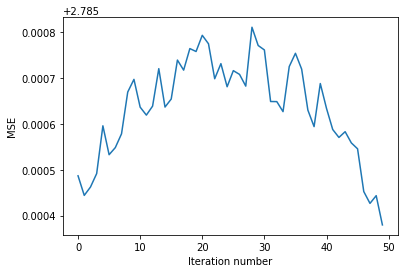

In [70]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

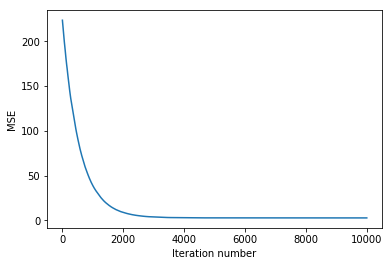

In [71]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Mini-batch gradient descent

Попытка сделать через матрицы, а не через цикл

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x^{T} \times (w^{T} \times x - y)^{T}}}$

In [72]:
def mini_batch_gradient_step(X, y, w, batch_size, train_ind, eta=0.01):
    l = len(y)

    i = 0
    x_k = np.zeros((batch_size, 4), dtype='float64')
    y_k = np.zeros(batch_size, dtype='float64')

    for i in range(batch_size - 1):
        x_k[i] = X.values[train_ind[i]]
        y_k[i] = y.values[train_ind[i]]

    return w + 2 * eta / l * np.dot(x_k.T, (y_k - np.dot(w.T, x_k.T).T))

In [73]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_gradient_step(X, y, w, batch_size, random_ind, eta=eta)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        print(weight_dist, min_weight_dist)
        print(iter_num)
        print('\n')
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [74]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)

0.012030968213711525 1e-08
1


0.011127129587986478 1e-08
2


0.01685128482977683 1e-08
3


0.024628254781668128 1e-08
4


0.014172546475151957 1e-08
5


0.014349291479228391 1e-08
6


0.011518358119656597 1e-08
7


0.021117116782545412 1e-08
8


0.01384062299273516 1e-08
9


0.01503401815601132 1e-08
10


0.013805364729800127 1e-08
11


0.013081182683855153 1e-08
12


0.011729234947434414 1e-08
13


0.021799007352454654 1e-08
14


0.01911554497367456 1e-08
15


0.013107653546977278 1e-08
16


0.013478770295815666 1e-08
17


0.011017219432845964 1e-08
18


0.017398521888303525 1e-08
19


0.019281754107857634 1e-08
20


0.02662915794515777 1e-08
21


0.01981549575825461 1e-08
22


0.011645524812565124 1e-08
23


0.011603538173973721 1e-08
24


0.015340267458488151 1e-08
25


0.012280034235758843 1e-08
26


0.021243694229812638 1e-08
27


0.018539637850239092 1e-08
28


0.011718434758899578 1e-08
29


0.01265372267130523 1e-08
30


0.011814218955815258 1e-08
31


0.011248760673867061 1e-

0.016688509584319108 1e-08
268


0.013514468908578109 1e-08
269


0.01588714351429215 1e-08
270


0.014366837205346067 1e-08
271


0.007077516676888843 1e-08
272


0.010621815157564366 1e-08
273


0.008356748516522749 1e-08
274


0.00962042179583907 1e-08
275


0.00895688660231357 1e-08
276


0.010944449636721152 1e-08
277


0.01109402047628066 1e-08
278


0.013667866960493116 1e-08
279


0.010549366874354885 1e-08
280


0.008632552865564464 1e-08
281


0.009521855235037931 1e-08
282


0.012843395332070127 1e-08
283


0.00950074119351028 1e-08
284


0.013664158420470817 1e-08
285


0.008729795399969138 1e-08
286


0.012189580676820919 1e-08
287


0.009062147668887134 1e-08
288


0.008909951552149993 1e-08
289


0.010139684607222543 1e-08
290


0.007771022020320701 1e-08
291


0.010519730183194369 1e-08
292


0.014736169746165333 1e-08
293


0.01132250924672968 1e-08
294


0.012463709030976216 1e-08
295


0.01135692027845238 1e-08
296


0.009991466427372952 1e-08
297


0.012024438459824

0.007375424414419191 1e-08
525


0.006493600372884067 1e-08
526


0.016034240457817317 1e-08
527


0.009917769901612207 1e-08
528


0.008635590777265424 1e-08
529


0.009246194071204122 1e-08
530


0.008995554267582516 1e-08
531


0.0066939265076147916 1e-08
532


0.012331078957728942 1e-08
533


0.008260193492308842 1e-08
534


0.011170580450727023 1e-08
535


0.013630341583221873 1e-08
536


0.010606514225363104 1e-08
537


0.00772812788662793 1e-08
538


0.008288345982477963 1e-08
539


0.01228703738807576 1e-08
540


0.008693594238247102 1e-08
541


0.00892236600713773 1e-08
542


0.010026173078547449 1e-08
543


0.007713166388965442 1e-08
544


0.010406575302272106 1e-08
545


0.008079961008042959 1e-08
546


0.013109132504438105 1e-08
547


0.009573295059720818 1e-08
548


0.008824359355542747 1e-08
549


0.00858722533233495 1e-08
550


0.009900441301374947 1e-08
551


0.006983009587539743 1e-08
552


0.010494919575485737 1e-08
553


0.00827258694209515 1e-08
554


0.012132027226

0.008032651229761262 1e-08
784


0.005922336252714241 1e-08
785


0.00751056778797243 1e-08
786


0.0078038592308729855 1e-08
787


0.006284032224748468 1e-08
788


0.005923567321125481 1e-08
789


0.007742508480104668 1e-08
790


0.0077160892928559216 1e-08
791


0.007908408814372336 1e-08
792


0.007165819982672646 1e-08
793


0.005367508234209005 1e-08
794


0.005165175370426006 1e-08
795


0.008309711757456744 1e-08
796


0.008813874957350696 1e-08
797


0.006306967066358137 1e-08
798


0.006306083765057587 1e-08
799


0.006215461207958299 1e-08
800


0.007228790159765791 1e-08
801


0.007915263643224297 1e-08
802


0.006679675053648749 1e-08
803


0.009133377945113463 1e-08
804


0.008734394734912285 1e-08
805


0.005309277903306004 1e-08
806


0.009575576507663061 1e-08
807


0.008572255538470797 1e-08
808


0.007333598364350694 1e-08
809


0.007137485495645597 1e-08
810


0.004869488806728458 1e-08
811


0.00573603605265488 1e-08
812


0.005874618290141145 1e-08
813


0.00698905

0.007819136877685895 1e-08
1041


0.005831116086610104 1e-08
1042


0.006533558549946498 1e-08
1043


0.005610448169254874 1e-08
1044


0.004769155548408649 1e-08
1045


0.004812381182650813 1e-08
1046


0.004585810244522581 1e-08
1047


0.005589544658397086 1e-08
1048


0.004050202344913388 1e-08
1049


0.006098327778015099 1e-08
1050


0.005543503813439731 1e-08
1051


0.004839074323494289 1e-08
1052


0.006170176103956781 1e-08
1053


0.005353587509979659 1e-08
1054


0.006807071659342446 1e-08
1055


0.004765431709908643 1e-08
1056


0.0061288570791735615 1e-08
1057


0.008635460171802835 1e-08
1058


0.005405363895135353 1e-08
1059


0.005242056642676007 1e-08
1060


0.005870583863707841 1e-08
1061


0.007045809583106046 1e-08
1062


0.008986172917910415 1e-08
1063


0.004867333701556291 1e-08
1064


0.005895467115807018 1e-08
1065


0.004042573411011931 1e-08
1066


0.0041440223112010266 1e-08
1067


0.004829933033470847 1e-08
1068


0.004969185616035863 1e-08
1069


0.0042648688

0.004119091921919518 1e-08
1297


0.004284275771925836 1e-08
1298


0.005365010227106874 1e-08
1299


0.005004356088103489 1e-08
1300


0.004285935437738421 1e-08
1301


0.0034987111615345217 1e-08
1302


0.0061208253885916865 1e-08
1303


0.006122486303102434 1e-08
1304


0.006087820185118339 1e-08
1305


0.002988221218141333 1e-08
1306


0.007056694505738388 1e-08
1307


0.004844063361506911 1e-08
1308


0.004210152565871896 1e-08
1309


0.005439417068433815 1e-08
1310


0.0030056380329231526 1e-08
1311


0.004160424770452985 1e-08
1312


0.004130145170404781 1e-08
1313


0.0046205408149415554 1e-08
1314


0.005438831124196357 1e-08
1315


0.00561267378087419 1e-08
1316


0.005076076073937142 1e-08
1317


0.004615083578054314 1e-08
1318


0.004117255730997751 1e-08
1319


0.003329242821918745 1e-08
1320


0.004180467635677786 1e-08
1321


0.003959653649263901 1e-08
1322


0.004574109666052284 1e-08
1323


0.005040236120470237 1e-08
1324


0.004107528240972307 1e-08
1325


0.004386432

0.003313319950879563 1e-08
1576


0.0029039442774389493 1e-08
1577


0.004338880645511898 1e-08
1578


0.005030579157056286 1e-08
1579


0.0026338830149266555 1e-08
1580


0.003036883257910176 1e-08
1581


0.004652486262716631 1e-08
1582


0.0032378018551218668 1e-08
1583


0.0037857862008537427 1e-08
1584


0.0024443115967538627 1e-08
1585


0.0031001655569273022 1e-08
1586


0.005236573015471454 1e-08
1587


0.003246993888467794 1e-08
1588


0.003929704841694929 1e-08
1589


0.004321563049882081 1e-08
1590


0.006725926830804482 1e-08
1591


0.004848095889721411 1e-08
1592


0.0037360218280272934 1e-08
1593


0.003608897984220184 1e-08
1594


0.004419800437028754 1e-08
1595


0.005668830659686488 1e-08
1596


0.00495104740120895 1e-08
1597


0.0037365662754137116 1e-08
1598


0.003855189005420668 1e-08
1599


0.004253422438024998 1e-08
1600


0.00291168636345763 1e-08
1601


0.004105493601967783 1e-08
1602


0.003633487805046442 1e-08
1603


0.002998304477116774 1e-08
1604


0.004238

0.0024877003355532066 1e-08
1815


0.0029198727895880195 1e-08
1816


0.002944455417656573 1e-08
1817


0.0032295915270701245 1e-08
1818


0.003326085142249101 1e-08
1819


0.004618643873834784 1e-08
1820


0.002531106687061201 1e-08
1821


0.0024814020426887923 1e-08
1822


0.0020011271235758636 1e-08
1823


0.0038920291807611595 1e-08
1824


0.0029048433813767473 1e-08
1825


0.0025267475706298257 1e-08
1826


0.003833142928274974 1e-08
1827


0.0028345272903164713 1e-08
1828


0.0030974884786381415 1e-08
1829


0.0025592209343642865 1e-08
1830


0.002318278792158317 1e-08
1831


0.0026951140897097416 1e-08
1832


0.002973618706281768 1e-08
1833


0.002572280397536195 1e-08
1834


0.003570051246163862 1e-08
1835


0.0024192819168030984 1e-08
1836


0.002997805997539737 1e-08
1837


0.0027578007951939475 1e-08
1838


0.003058120623445314 1e-08
1839


0.0026636758733577523 1e-08
1840


0.006605398658988691 1e-08
1841


0.003074258646659593 1e-08
1842


0.0026452287822032253 1e-08
1843


0.0023520010901641876 1e-08
2054


0.0022233537956301394 1e-08
2055


0.0019478011297259258 1e-08
2056


0.001723059878198742 1e-08
2057


0.0028406500903558063 1e-08
2058


0.0013970308546556853 1e-08
2059


0.0020749064085846323 1e-08
2060


0.003470646562735404 1e-08
2061


0.003158197905748864 1e-08
2062


0.0019835657413500574 1e-08
2063


0.0052619838343807715 1e-08
2064


0.0019059341528002407 1e-08
2065


0.002195821692085193 1e-08
2066


0.0034001064914136268 1e-08
2067


0.0021914467554511497 1e-08
2068


0.0016497318702748144 1e-08
2069


0.0019415543111485493 1e-08
2070


0.0022231041476702966 1e-08
2071


0.003475272408383187 1e-08
2072


0.002257911191634974 1e-08
2073


0.0024353397085069904 1e-08
2074


0.003144969887424905 1e-08
2075


0.0031195212538415377 1e-08
2076


0.0027820652492204366 1e-08
2077


0.0014531431238229318 1e-08
2078


0.001719647246179153 1e-08
2079


0.0024253727225371138 1e-08
2080


0.002712924258897599 1e-08
2081


0.0016715187396381264 1e-08
2

0.002841945740584285 1e-08
2303


0.0045666281424584666 1e-08
2304


0.002685445544102508 1e-08
2305


0.0017561086439943385 1e-08
2306


0.0022358753578376914 1e-08
2307


0.0024655371267898983 1e-08
2308


0.002744975859158832 1e-08
2309


0.002113554961707843 1e-08
2310


0.002951240873604497 1e-08
2311


0.0021067776860159947 1e-08
2312


0.001569813042809058 1e-08
2313


0.0017283688615581968 1e-08
2314


0.0011477933182535544 1e-08
2315


0.0023143513671317105 1e-08
2316


0.002662490406251458 1e-08
2317


0.001421861056494283 1e-08
2318


0.0016933695747984182 1e-08
2319


0.0025761473787052204 1e-08
2320


0.00214712181783951 1e-08
2321


0.0012302893375569952 1e-08
2322


0.0017153335129201635 1e-08
2323


0.001584483819345181 1e-08
2324


0.0025504155136164093 1e-08
2325


0.0025879481621868226 1e-08
2326


0.003103549131381922 1e-08
2327


0.0024318778582257117 1e-08
2328


0.0011940162994629776 1e-08
2329


0.0013813846991452083 1e-08
2330


0.002082041206990437 1e-08
2331


0.0015397906696731855 1e-08
2550


0.0012822207306385975 1e-08
2551


0.0013103771494652693 1e-08
2552


0.0013984382409588797 1e-08
2553


0.0012322721440811738 1e-08
2554


0.002760435046862521 1e-08
2555


0.001698928108393542 1e-08
2556


0.0019134626931185225 1e-08
2557


0.003690612375634642 1e-08
2558


0.0022712500646337756 1e-08
2559


0.0010213606388828015 1e-08
2560


0.001337450203118105 1e-08
2561


0.0013990833042235836 1e-08
2562


0.0015851233805166194 1e-08
2563


0.0011084371100869791 1e-08
2564


0.0017892023559305124 1e-08
2565


0.0018189585386325928 1e-08
2566


0.0011917099275494157 1e-08
2567


0.0015474547374735885 1e-08
2568


0.0026208118783281886 1e-08
2569


0.0017938162807939772 1e-08
2570


0.002404846540552672 1e-08
2571


0.0023470491644092383 1e-08
2572


0.001996000049070192 1e-08
2573


0.00048455990226505333 1e-08
2574


0.0016685190571292874 1e-08
2575


0.0016495484247878623 1e-08
2576


0.001521790919680436 1e-08
2577


0.002018909806900378 1e-08

0.0007683385634411071 1e-08
2787


0.0009310426934364786 1e-08
2788


0.0022370399512468596 1e-08
2789


0.0021294638193992774 1e-08
2790


0.002220170915593409 1e-08
2791


0.0010815477482790136 1e-08
2792


0.0024974651713007565 1e-08
2793


0.0014904930919446893 1e-08
2794


0.0006079654360560947 1e-08
2795


0.0029944087982587985 1e-08
2796


0.0015490213443866173 1e-08
2797


0.0007579240341861617 1e-08
2798


0.0012707805635602182 1e-08
2799


0.0010939114937437314 1e-08
2800


0.0011471159698738461 1e-08
2801


0.0006429541684244898 1e-08
2802


0.001216509509201724 1e-08
2803


0.0016315940359489577 1e-08
2804


0.001417899363374528 1e-08
2805


0.0017832384692583816 1e-08
2806


0.0011234174645041106 1e-08
2807


0.0014416839636152937 1e-08
2808


0.0021577697308823402 1e-08
2809


0.0011582036529809996 1e-08
2810


0.0007559458744043368 1e-08
2811


0.0008600664654531187 1e-08
2812


0.0023807633880535 1e-08
2813


0.0011491557775957736 1e-08
2814


0.002013457679954862 1e-08

0.0012168665061416978 1e-08
3044


0.0013503913816568236 1e-08
3045


0.0021426046635282525 1e-08
3046


0.0010492793962060452 1e-08
3047


0.0016631254553009912 1e-08
3048


0.0014575579505262956 1e-08
3049


0.0007920187915332704 1e-08
3050


0.0033768497857837605 1e-08
3051


0.0017009101857002752 1e-08
3052


0.002337046544397334 1e-08
3053


0.0017945764752402536 1e-08
3054


0.0012599112422976744 1e-08
3055


0.0017588772435218102 1e-08
3056


0.0008307019054822044 1e-08
3057


0.0014798381440270592 1e-08
3058


0.001223862815302353 1e-08
3059


0.0013199634179552374 1e-08
3060


0.0011230368190660676 1e-08
3061


0.000937948330655101 1e-08
3062


0.0018652120312691591 1e-08
3063


0.00099847163447029 1e-08
3064


0.001931830606019444 1e-08
3065


0.0011814446162930084 1e-08
3066


0.0009009851815803138 1e-08
3067


0.00044831535813681477 1e-08
3068


0.0008240615049949835 1e-08
3069


0.0012621453143272683 1e-08
3070


0.0017921066216781475 1e-08
3071


0.0019099038330581545 1e-

0.0015644804571581209 1e-08
3298


0.0010320059151469646 1e-08
3299


0.0011220507674491293 1e-08
3300


0.0007502996859205389 1e-08
3301


0.0036230393943421494 1e-08
3302


0.0019030864035128753 1e-08
3303


0.0004899360230561031 1e-08
3304


0.0016599758697069247 1e-08
3305


0.0026830917202502664 1e-08
3306


0.001023375523119992 1e-08
3307


0.0010790179120452551 1e-08
3308


0.0019381464156284862 1e-08
3309


0.0010903836017789469 1e-08
3310


0.0010798006589029143 1e-08
3311


0.0009698087498126555 1e-08
3312


0.0016967598204444012 1e-08
3313


0.0007371750756963052 1e-08
3314


0.0016581724556773104 1e-08
3315


0.001195452402080559 1e-08
3316


0.0015444440967237842 1e-08
3317


0.001261223878227745 1e-08
3318


0.0007422800100602507 1e-08
3319


0.00126807784096671 1e-08
3320


0.001241514323500991 1e-08
3321


0.0012690082621277978 1e-08
3322


0.00212822997971304 1e-08
3323


0.0020988695536276894 1e-08
3324


0.001852919618962844 1e-08
3325


0.0015308198139770844 1e-08
3

0.0007747067426884718 1e-08
3546


0.0009878235668916448 1e-08
3547


0.0008287253511926452 1e-08
3548


0.002151208617317848 1e-08
3549


0.0012076972868736843 1e-08
3550


0.0022554908216433026 1e-08
3551


0.0017548726241924863 1e-08
3552


0.0015136209412136474 1e-08
3553


0.0004130590397614901 1e-08
3554


0.0011740992149519925 1e-08
3555


0.001581702783670348 1e-08
3556


0.002563948145663892 1e-08
3557


0.0010196509243573665 1e-08
3558


0.0012496837222071063 1e-08
3559


0.0008309266658755655 1e-08
3560


0.0007362838133453148 1e-08
3561


0.0010552009414827514 1e-08
3562


0.0012425325739970061 1e-08
3563


0.001205992142321013 1e-08
3564


0.0006118530989884057 1e-08
3565


0.0010753527070677142 1e-08
3566


0.0016892026135408903 1e-08
3567


0.0017881270767666074 1e-08
3568


0.0005676203846336701 1e-08
3569


0.0008229709976677284 1e-08
3570


0.0012501226247950531 1e-08
3571


0.0013453291134797878 1e-08
3572


0.0005726689105832559 1e-08
3573


0.0008564703626910034 1e

0.0016145109202884516 1e-08
3785


0.0008468142091695302 1e-08
3786


0.0013072089666940848 1e-08
3787


0.0008782254261433172 1e-08
3788


0.0006872982467066189 1e-08
3789


0.0010082019238286848 1e-08
3790


0.0009406504177450108 1e-08
3791


0.0008032778436413343 1e-08
3792


0.000336067702817637 1e-08
3793


0.0007569013664746936 1e-08
3794


0.0009444487991057401 1e-08
3795


0.0012539162133087098 1e-08
3796


0.0007116007396506533 1e-08
3797


0.0014295296792063799 1e-08
3798


0.0007764237524073859 1e-08
3799


0.001186740707158353 1e-08
3800


0.0006235941658252811 1e-08
3801


0.00183892374726182 1e-08
3802


0.002919905043888178 1e-08
3803


0.0012863147117073547 1e-08
3804


0.0017269680866406033 1e-08
3805


0.0005475543978464016 1e-08
3806


0.00022990491495954982 1e-08
3807


0.0017842735012293515 1e-08
3808


0.0011084569171549807 1e-08
3809


0.0004168002001592371 1e-08
3810


0.0017651640386238013 1e-08
3811


0.0013646350080952063 1e-08
3812


0.0006059981894792843 1e

0.0013732151861163807 1e-08
4030


0.0010642338936046423 1e-08
4031


0.001310421123615919 1e-08
4032


0.0013126812509581766 1e-08
4033


0.001735600605601775 1e-08
4034


0.001208806952434538 1e-08
4035


0.0009150266121523097 1e-08
4036


0.0009306133443833196 1e-08
4037


0.0014283971510223228 1e-08
4038


0.0012215920164323677 1e-08
4039


0.0007205523329584169 1e-08
4040


0.000679109864752339 1e-08
4041


0.0010531448455564836 1e-08
4042


0.0009320583684356969 1e-08
4043


0.000820160984040535 1e-08
4044


0.0005026856972920752 1e-08
4045


0.002297552981779091 1e-08
4046


0.0007828907291517716 1e-08
4047


0.0014164225124937372 1e-08
4048


0.0009523968391623997 1e-08
4049


0.0019392129034084193 1e-08
4050


0.000701335247629158 1e-08
4051


0.0009975717772977744 1e-08
4052


0.0013252421375280965 1e-08
4053


0.0009975019140549054 1e-08
4054


0.0007854595325986628 1e-08
4055


0.0010684201015214098 1e-08
4056


0.0010746118657461233 1e-08
4057


0.00125080873155329 1e-08
4

0.0009745198269575846 1e-08
4277


0.001949351932407329 1e-08
4278


0.0013546245071940457 1e-08
4279


0.0011562493254103745 1e-08
4280


0.0006910466259825049 1e-08
4281


0.0013904340340172281 1e-08
4282


0.0006325624680369403 1e-08
4283


0.0002958750564301802 1e-08
4284


0.0006686049059294418 1e-08
4285


0.0010222773769126335 1e-08
4286


0.0011684379206807888 1e-08
4287


0.0007602680438390238 1e-08
4288


0.0008064941717605906 1e-08
4289


0.0010424143906450848 1e-08
4290


0.0004910504808513121 1e-08
4291


0.00025199202637480933 1e-08
4292


0.001096054953048117 1e-08
4293


0.0005530363698038215 1e-08
4294


0.0006778214190482475 1e-08
4295


0.0005776065452305505 1e-08
4296


0.0011561672335778685 1e-08
4297


0.001042792864778678 1e-08
4298


0.0004485314381593747 1e-08
4299


0.0004531187792207456 1e-08
4300


0.0011819063179975726 1e-08
4301


0.0007543786665733293 1e-08
4302


0.000757233629854498 1e-08
4303


0.0005175670635027274 1e-08
4304


0.0005576948910919924 1

0.0014083660522321891 1e-08
4519


0.0014753482644105302 1e-08
4520


0.001111104029361752 1e-08
4521


0.0009400878133209404 1e-08
4522


0.0011899024366077988 1e-08
4523


0.000697840450153722 1e-08
4524


0.000651830535398693 1e-08
4525


0.0008950806138684549 1e-08
4526


0.0006850346587785111 1e-08
4527


0.0008111431606349245 1e-08
4528


0.0004184071768386726 1e-08
4529


0.0007467434998581528 1e-08
4530


0.0009446133713065832 1e-08
4531


0.00121011194059425 1e-08
4532


0.0008499465256555788 1e-08
4533


0.0021919199980003218 1e-08
4534


0.0011650206201563413 1e-08
4535


0.0011919704355053459 1e-08
4536


0.0018548594409244657 1e-08
4537


0.001480913392749428 1e-08
4538


0.0011910319716554143 1e-08
4539


0.0005436377178252632 1e-08
4540


0.0008036509009842061 1e-08
4541


0.0017061532313260629 1e-08
4542


0.0010570976041959761 1e-08
4543


0.0011683809463129077 1e-08
4544


0.0009297372885264257 1e-08
4545


0.001314619163167435 1e-08
4546


0.0006336181957834038 1e-08

0.0012164259509442233 1e-08
4766


0.0011734809121888153 1e-08
4767


0.0015084570250933017 1e-08
4768


0.0008076490407329546 1e-08
4769


0.0021295518258138695 1e-08
4770


0.0004595447726416236 1e-08
4771


0.000502126690353405 1e-08
4772


0.0010234584712237303 1e-08
4773


0.001075943411487775 1e-08
4774


0.0008137425477000642 1e-08
4775


0.0007070166865331946 1e-08
4776


0.001124069998706594 1e-08
4777


0.0014452343558383905 1e-08
4778


0.0015983842669038322 1e-08
4779


0.0008795560955394983 1e-08
4780


0.00023990589828264076 1e-08
4781


0.0010442452736524176 1e-08
4782


0.0007883235136583101 1e-08
4783


0.0008706257044401328 1e-08
4784


0.0008547965450292078 1e-08
4785


0.0012721588408468468 1e-08
4786


0.0008317661256462847 1e-08
4787


0.0020435013742412375 1e-08
4788


0.0013835946468717586 1e-08
4789


0.0013341486755413126 1e-08
4790


0.0007880999791123164 1e-08
4791


0.0011745043603398333 1e-08
4792


0.0003859786627996545 1e-08
4793


0.0011637189360584103 

0.0009032921312256885 1e-08
5012


0.0007777222926768556 1e-08
5013


0.0005944192116732469 1e-08
5014


0.000734538443700363 1e-08
5015


0.0006262831132835127 1e-08
5016


0.0009505151027082273 1e-08
5017


0.0007491057983860014 1e-08
5018


0.0010263579811531584 1e-08
5019


0.0011466674367202018 1e-08
5020


0.0008446136316202157 1e-08
5021


0.0011637952217373932 1e-08
5022


0.0005401086064962386 1e-08
5023


0.0025735648315768174 1e-08
5024


0.0009464608969870776 1e-08
5025


0.0015064801906779005 1e-08
5026


0.001111465765184675 1e-08
5027


0.0006179222988866131 1e-08
5028


0.0009672393257684248 1e-08
5029


0.002285770577029766 1e-08
5030


0.0014090604820323803 1e-08
5031


0.0011570808902513427 1e-08
5032


0.0008367104123810904 1e-08
5033


0.00026825733468265013 1e-08
5034


0.0013592773731889484 1e-08
5035


0.0008579994680696482 1e-08
5036


0.0013664077975937593 1e-08
5037


0.0007246078612479996 1e-08
5038


0.0014825739172733803 1e-08
5039


0.0007074995155749637 

0.0004416575988044817 1e-08
5258


0.0014465073349898341 1e-08
5259


0.0005779140123274048 1e-08
5260


0.0008870308824613303 1e-08
5261


0.0021650291986729368 1e-08
5262


0.001110466005684361 1e-08
5263


0.0009507913797837352 1e-08
5264


0.0006808393155229791 1e-08
5265


0.0008198456590047157 1e-08
5266


0.000524709980463256 1e-08
5267


0.0006444675806232643 1e-08
5268


0.0018507999894448479 1e-08
5269


0.0006580403310491712 1e-08
5270


0.001776056725614448 1e-08
5271


0.0015488793688450747 1e-08
5272


0.0008966545942770619 1e-08
5273


0.0007639041878682699 1e-08
5274


0.0008907526184389198 1e-08
5275


0.0011093920056826627 1e-08
5276


0.0014297299149287463 1e-08
5277


0.0015479081655875833 1e-08
5278


0.001423057941724919 1e-08
5279


0.0009352336007821142 1e-08
5280


0.0013293913767788584 1e-08
5281


0.0009643146518665157 1e-08
5282


0.0006414944901400082 1e-08
5283


0.001608724514769811 1e-08
5284


0.0011675512229894188 1e-08
5285


0.0008343837692401082 1e-

0.0007649676835224979 1e-08
5497


0.0006614745509426719 1e-08
5498


0.0008526052206638587 1e-08
5499


0.0007294784612896615 1e-08
5500


0.0008804883988244717 1e-08
5501


0.0007154116437954428 1e-08
5502


0.0008855665003253013 1e-08
5503


0.00043475703413901087 1e-08
5504


0.0011578998329969108 1e-08
5505


0.00034416973517684856 1e-08
5506


0.0006918621375255303 1e-08
5507


0.0006718484967369738 1e-08
5508


0.0012310175355342682 1e-08
5509


0.0006844454756069894 1e-08
5510


0.0003936985143250475 1e-08
5511


0.0007232913382151919 1e-08
5512


0.0007653327984769594 1e-08
5513


0.0018887628953239322 1e-08
5514


0.0005449935595670212 1e-08
5515


0.0008371699721993297 1e-08
5516


0.0007421360451397213 1e-08
5517


0.001791195295540618 1e-08
5518


0.000872562366345274 1e-08
5519


0.0010410957263152182 1e-08
5520


0.0008400886220059628 1e-08
5521


0.003457282311894473 1e-08
5522


0.0015842193985011385 1e-08
5523


0.001134761768899072 1e-08
5524


0.00048343629140670303

0.0012132856231457402 1e-08
5770


0.00028968322245531773 1e-08
5771


0.001376512900113761 1e-08
5772


0.003056042498996052 1e-08
5773


0.00021864601286171426 1e-08
5774


0.0012774632623778273 1e-08
5775


0.0012004589059385396 1e-08
5776


0.001430504315541864 1e-08
5777


0.0010905043880568934 1e-08
5778


0.000738438467818088 1e-08
5779


0.0006978768284380336 1e-08
5780


0.0010328239714266388 1e-08
5781


0.001230734087290581 1e-08
5782


0.00062257089644462 1e-08
5783


0.0013218853068367867 1e-08
5784


0.0008486096910384883 1e-08
5785


0.0011245432203170036 1e-08
5786


0.0006315778201299031 1e-08
5787


0.0010885484750570353 1e-08
5788


0.0012054388741678215 1e-08
5789


0.0008424147979006077 1e-08
5790


0.001306835148517901 1e-08
5791


0.0003832577632977931 1e-08
5792


0.00045216645441696233 1e-08
5793


0.000701667494844785 1e-08
5794


0.0005675543331813313 1e-08
5795


0.0008046040378519716 1e-08
5796


0.0010687643198122798 1e-08
5797


0.0013528237476359561 1e-0

0.000978102725289482 1e-08
6020


0.0007764973764324368 1e-08
6021


0.001150421764840827 1e-08
6022


0.00157651428510734 1e-08
6023


0.0004133040709215798 1e-08
6024


0.0005718714182896807 1e-08
6025


0.0005030845719108592 1e-08
6026


0.0010312675291706895 1e-08
6027


0.0007727820979868123 1e-08
6028


0.00017986312863017785 1e-08
6029


0.0013145758383936426 1e-08
6030


0.001549095554918276 1e-08
6031


0.0006095650552090518 1e-08
6032


0.0008030609154656346 1e-08
6033


0.0006319943482631792 1e-08
6034


0.001204299235837599 1e-08
6035


0.0009210005403738997 1e-08
6036


0.000577462363801629 1e-08
6037


0.001061195316196449 1e-08
6038


0.001055581534436341 1e-08
6039


0.0008099847691065632 1e-08
6040


0.0013700714772728357 1e-08
6041


0.0008427399862443072 1e-08
6042


0.00044233624330342606 1e-08
6043


0.00040393647043957367 1e-08
6044


0.0018468610164538682 1e-08
6045


0.0004989105307330675 1e-08
6046


0.0008890363347091744 1e-08
6047


0.0008286348426691187 1e-0

0.0007801014515581504 1e-08
6266


0.00259334706660534 1e-08
6267


0.0008003989466007223 1e-08
6268


0.001001854466332108 1e-08
6269


0.0005435477375787645 1e-08
6270


0.0008074753218259074 1e-08
6271


0.0009734201135282553 1e-08
6272


0.0006550775228594083 1e-08
6273


0.0010162175893032703 1e-08
6274


0.0012419822679843452 1e-08
6275


0.00041332380867473335 1e-08
6276


0.0012884521347738059 1e-08
6277


0.0011073295216475145 1e-08
6278


0.0016186192479213518 1e-08
6279


0.0007950810942641118 1e-08
6280


0.0015686663629347185 1e-08
6281


0.000699993162501513 1e-08
6282


0.0006374161789938542 1e-08
6283


0.0009577389169047332 1e-08
6284


0.0007153404797393774 1e-08
6285


0.0009577261637194066 1e-08
6286


0.0006843466020320744 1e-08
6287


0.0006473512209736701 1e-08
6288


0.0006918396646605717 1e-08
6289


0.0007071828788617013 1e-08
6290


0.0009145407247639349 1e-08
6291


0.00041093177037958517 1e-08
6292


0.0007966901640001512 1e-08
6293


0.0006262611543961328 

0.0010719710768531375 1e-08
6511


0.003734881431928515 1e-08
6512


0.0013621922177139661 1e-08
6513


0.0011417973160423838 1e-08
6514


0.0028599352479666863 1e-08
6515


0.0009175597263597324 1e-08
6516


0.0008767967535565647 1e-08
6517


0.0010860554348363844 1e-08
6518


0.0010596675120443596 1e-08
6519


0.0011172069907380764 1e-08
6520


0.001401090346197782 1e-08
6521


0.000835110591294849 1e-08
6522


0.00036491022947056606 1e-08
6523


0.0004334553211823161 1e-08
6524


0.001217114798827031 1e-08
6525


0.0005536657104893762 1e-08
6526


0.0021085993459643857 1e-08
6527


0.0011932311862498843 1e-08
6528


0.0012119516542874844 1e-08
6529


0.0011356620456035283 1e-08
6530


0.0007721890046836163 1e-08
6531


0.0004938462910926197 1e-08
6532


0.0021378278754601455 1e-08
6533


0.0009569232127091768 1e-08
6534


0.0012702393198603897 1e-08
6535


0.0007544503008945743 1e-08
6536


0.0011528926357288745 1e-08
6537


0.0009753391004456792 1e-08
6538


0.00045599219073235364 

0.0019657617043887677 1e-08
6749


0.000663334709719739 1e-08
6750


0.0006718510632170115 1e-08
6751


0.0007004664698643457 1e-08
6752


0.0010610003817074698 1e-08
6753


0.000375924771307838 1e-08
6754


0.0009866749003529767 1e-08
6755


0.0007321215343819726 1e-08
6756


0.0008779256761004577 1e-08
6757


0.0009320319949072701 1e-08
6758


0.001804094861417524 1e-08
6759


0.0009435380084379244 1e-08
6760


0.0012807147663296667 1e-08
6761


0.0032515865795024867 1e-08
6762


0.0015116959668530446 1e-08
6763


0.0006944340657159741 1e-08
6764


0.0018284194886064376 1e-08
6765


0.0010998042287418972 1e-08
6766


0.0004701607542543809 1e-08
6767


0.0011223644175642684 1e-08
6768


0.0007824971091871354 1e-08
6769


0.0007196993705993431 1e-08
6770


0.0010555597906275799 1e-08
6771


0.00138049074307759 1e-08
6772


0.0013168380304718732 1e-08
6773


0.0007546681753021462 1e-08
6774


0.0018926092758222773 1e-08
6775


0.0012599271853101154 1e-08
6776


0.000538671859477756 1e-0

0.0010248339478558038 1e-08
6996


0.000639979988981251 1e-08
6997


0.0006189951386192335 1e-08
6998


0.0022353086372085052 1e-08
6999


0.0012301784752566677 1e-08
7000


0.0017035795300520216 1e-08
7001


0.0015072878339841438 1e-08
7002


0.000554211778448978 1e-08
7003


0.0007037943330052213 1e-08
7004


0.0006212173966034803 1e-08
7005


0.0010037816557623093 1e-08
7006


0.00043349156459617427 1e-08
7007


0.00039634334610669426 1e-08
7008


0.00029921748672128915 1e-08
7009


0.00033855412683762365 1e-08
7010


0.0006850719317936918 1e-08
7011


0.0015363685587978851 1e-08
7012


0.0008685963857661519 1e-08
7013


0.0013380899662863129 1e-08
7014


0.0031257367797186478 1e-08
7015


0.0009330593075116113 1e-08
7016


0.001184222709988206 1e-08
7017


0.0007265248668644248 1e-08
7018


0.0009408833515143468 1e-08
7019


0.0013769812313542012 1e-08
7020


0.0006646281397211197 1e-08
7021


0.0007961171471101496 1e-08
7022


0.0008830465340427823 1e-08
7023


0.00071696236126488

0.0008791760478564877 1e-08
7240


0.0011136821357956132 1e-08
7241


0.0007121940706224674 1e-08
7242


0.0009803266145812653 1e-08
7243


0.002208730819762066 1e-08
7244


0.0010463810499109557 1e-08
7245


0.0007867863598050044 1e-08
7246


0.0005183231237725466 1e-08
7247


0.00098316409107703 1e-08
7248


0.001852464952055846 1e-08
7249


0.0009026890229835959 1e-08
7250


0.0008768006738536968 1e-08
7251


0.0008286051818838648 1e-08
7252


0.0010043752641881835 1e-08
7253


0.0009252709285648648 1e-08
7254


0.00032160314565900315 1e-08
7255


0.0012573854513419005 1e-08
7256


0.002541456744734848 1e-08
7257


0.0011355656866623225 1e-08
7258


0.001962592073870584 1e-08
7259


0.0006294809225023312 1e-08
7260


0.0009208279558294962 1e-08
7261


0.001075798321235825 1e-08
7262


0.0014122184118182865 1e-08
7263


0.0010177510562364293 1e-08
7264


0.00042995970115695237 1e-08
7265


0.0005946534699237435 1e-08
7266


0.001421029490964091 1e-08
7267


0.000733672660902323 1e-08

0.000690664109491179 1e-08
7481


0.0014744358917825008 1e-08
7482


0.0012479638949088785 1e-08
7483


0.0011290504004325024 1e-08
7484


0.0016993326633851895 1e-08
7485


0.0011307898697163704 1e-08
7486


0.0008581016310801754 1e-08
7487


0.0010695629310862066 1e-08
7488


0.0011935180616642145 1e-08
7489


0.0006209177539202134 1e-08
7490


0.001685110944741586 1e-08
7491


0.0009487306043951933 1e-08
7492


0.0007925578836448424 1e-08
7493


0.0018688986814928052 1e-08
7494


0.0008401340886031496 1e-08
7495


0.001314517253238178 1e-08
7496


0.000844204012725752 1e-08
7497


0.0015058960093947125 1e-08
7498


0.0006126427721582442 1e-08
7499


0.0012585355292443834 1e-08
7500


0.0005818349192776912 1e-08
7501


0.0017057938017966442 1e-08
7502


0.00019414600707264777 1e-08
7503


0.0012088241283598475 1e-08
7504


0.0005693314886092318 1e-08
7505


0.0007939847386413503 1e-08
7506


0.0011961553270002211 1e-08
7507


0.0007361231546612923 1e-08
7508


0.0006854759507048796 1

0.0011717946524951522 1e-08
7726


0.0010555050028524379 1e-08
7727


0.0025608569135266005 1e-08
7728


0.0006874747857513929 1e-08
7729


0.0007480509727115195 1e-08
7730


0.0012113093024303063 1e-08
7731


0.0015769543457979616 1e-08
7732


0.000714313750291788 1e-08
7733


0.0005866347696226273 1e-08
7734


0.0012260190527952017 1e-08
7735


0.0010558048212659281 1e-08
7736


0.00035290270106641986 1e-08
7737


0.0009617703583040428 1e-08
7738


0.0009262448887440865 1e-08
7739


0.0006582414265220439 1e-08
7740


0.0005903134403636444 1e-08
7741


0.0004368388651723618 1e-08
7742


0.0026182476316039937 1e-08
7743


0.0010828981177397703 1e-08
7744


0.0008378846057308066 1e-08
7745


0.001294336580582312 1e-08
7746


0.0004022346738674002 1e-08
7747


0.0010996528719379281 1e-08
7748


0.0019015490780745301 1e-08
7749


0.0007935697872330539 1e-08
7750


0.0003434097848071525 1e-08
7751


0.0006356776347436628 1e-08
7752


0.000750984315769115 1e-08
7753


0.0012596141580707584 

0.0008299988540977882 1e-08
7969


0.0014230387966997593 1e-08
7970


0.001763792392236333 1e-08
7971


0.0006724080585108705 1e-08
7972


0.0007335530720313116 1e-08
7973


0.0005926741120258662 1e-08
7974


0.0006655357414296848 1e-08
7975


0.0015287282469932566 1e-08
7976


0.0014545685709269895 1e-08
7977


0.002610840823929201 1e-08
7978


0.00035232621229693353 1e-08
7979


0.0019148403098210984 1e-08
7980


0.000790453095480648 1e-08
7981


0.00042066318212480747 1e-08
7982


0.0011880009665456528 1e-08
7983


0.0010292108595428076 1e-08
7984


0.00036122732640248516 1e-08
7985


0.0008257058329220028 1e-08
7986


0.0010818229332041907 1e-08
7987


0.0008997758938504814 1e-08
7988


0.0004865902738088068 1e-08
7989


0.0006946048134869117 1e-08
7990


0.0005519472041451802 1e-08
7991


0.0007435413068013239 1e-08
7992


0.0008826404135068922 1e-08
7993


0.0010123697048842095 1e-08
7994


0.0009157003221215163 1e-08
7995


0.0005365096648864422 1e-08
7996


0.001462208508722738

0.0006707623134411939 1e-08
8209


0.001162651691213493 1e-08
8210


0.0008710260065985807 1e-08
8211


0.0019009236436410971 1e-08
8212


0.0009477214463488056 1e-08
8213


0.0011631280408270345 1e-08
8214


0.001277829262132226 1e-08
8215


0.002757126582287412 1e-08
8216


0.0015581996584215717 1e-08
8217


0.0008927483046709318 1e-08
8218


0.000884366877971053 1e-08
8219


0.0006179940377381737 1e-08
8220


0.001145454875728819 1e-08
8221


0.0008378758567747875 1e-08
8222


0.0006716500076486293 1e-08
8223


0.0008024699397847198 1e-08
8224


0.0011173401598241575 1e-08
8225


0.0021550641942890167 1e-08
8226


0.000786735390894225 1e-08
8227


0.000962330827666218 1e-08
8228


0.0007543650098865492 1e-08
8229


0.000761535366076424 1e-08
8230


0.0007099430161904305 1e-08
8231


0.0022617063202647007 1e-08
8232


0.001008954987146243 1e-08
8233


0.0007736975658250244 1e-08
8234


0.0007089411114219507 1e-08
8235


0.0005943103368963133 1e-08
8236


0.0011798727748742505 1e-08
8

0.0019645482220778006 1e-08
8448


0.000999703614964204 1e-08
8449


0.0016739636146255116 1e-08
8450


0.0009084193012142027 1e-08
8451


0.0013918287276618326 1e-08
8452


0.0008040652679793343 1e-08
8453


0.0006366479727171298 1e-08
8454


0.0016612523276142558 1e-08
8455


0.0008132466065909985 1e-08
8456


0.0006207294427914186 1e-08
8457


0.00028831953547775094 1e-08
8458


0.0007556890613591419 1e-08
8459


0.002232617329623161 1e-08
8460


0.0009367863779172779 1e-08
8461


0.0011360515878016994 1e-08
8462


0.0011405808577481895 1e-08
8463


0.0009116726511328185 1e-08
8464


0.0020381947890587876 1e-08
8465


0.000662711789645321 1e-08
8466


0.0006268467004293306 1e-08
8467


0.001434111537355509 1e-08
8468


0.001055957699163079 1e-08
8469


0.000597955260283611 1e-08
8470


0.0013420069816075498 1e-08
8471


0.0009884273192722367 1e-08
8472


0.0018942342398927388 1e-08
8473


0.0004918453382803786 1e-08
8474


0.00038244589533938724 1e-08
8475


0.0006498033283926702 1e

0.0009653075135326756 1e-08
8691


0.0009100403717569062 1e-08
8692


0.0010652064775021283 1e-08
8693


0.0006304914546165428 1e-08
8694


0.0012692387721849469 1e-08
8695


0.000984102412835359 1e-08
8696


0.001121348158694267 1e-08
8697


0.0010359008265320973 1e-08
8698


0.0005484387668027484 1e-08
8699


0.0006966778357443654 1e-08
8700


0.0005447101583232618 1e-08
8701


0.0006454949621484151 1e-08
8702


0.0010877093026239704 1e-08
8703


0.0011696424095286161 1e-08
8704


0.0005672741975543326 1e-08
8705


0.00026435857399315 1e-08
8706


0.0011429733562714982 1e-08
8707


0.0014806753383109765 1e-08
8708


0.0011054319826665437 1e-08
8709


0.0006920777867228743 1e-08
8710


0.0016139970404092405 1e-08
8711


0.0013366834128395756 1e-08
8712


0.0009472981591883609 1e-08
8713


0.0016837350619292864 1e-08
8714


0.00044061748265435667 1e-08
8715


0.0009362219791265274 1e-08
8716


0.0003656161322814453 1e-08
8717


0.0007538135905398849 1e-08
8718


0.0007384288686556495 1

0.0012087494068781643 1e-08
8946


0.0009250708154565222 1e-08
8947


0.0007133867972800191 1e-08
8948


0.0011647534945183264 1e-08
8949


0.001150873843794896 1e-08
8950


0.0009227907840955639 1e-08
8951


0.001722020099562016 1e-08
8952


0.001297963357908718 1e-08
8953


0.000797571853423242 1e-08
8954


0.0010827587789044284 1e-08
8955


0.0023084825498941052 1e-08
8956


0.0012635288353524052 1e-08
8957


0.0003732012359621406 1e-08
8958


0.0008904387777650748 1e-08
8959


0.000833694672642536 1e-08
8960


0.001009532629092692 1e-08
8961


0.0006791521415413003 1e-08
8962


0.0011656588575872002 1e-08
8963


0.0014978074518660785 1e-08
8964


0.000248303434861356 1e-08
8965


0.0018780804726657165 1e-08
8966


0.0013110467534117177 1e-08
8967


0.001013109521221102 1e-08
8968


0.0013331797237062868 1e-08
8969


0.0009833437343602339 1e-08
8970


0.0022038722003804513 1e-08
8971


0.0010897434216925771 1e-08
8972


0.0006632488089970962 1e-08
8973


0.001812030089387638 1e-08
8

0.0007747807425293679 1e-08
9199


0.0007235362812722485 1e-08
9200


0.001162252170967321 1e-08
9201


0.0005902442269565151 1e-08
9202


0.0008101730326586425 1e-08
9203


0.0008936053413930701 1e-08
9204


0.0008148749089981594 1e-08
9205


0.0007236905101674105 1e-08
9206


0.0009062927819354959 1e-08
9207


0.0009254736657311949 1e-08
9208


0.0007471543253404698 1e-08
9209


0.0026393937091517003 1e-08
9210


0.0011492484329435717 1e-08
9211


0.0012076592339263247 1e-08
9212


0.0009098608152223806 1e-08
9213


0.0010451162948524962 1e-08
9214


0.001323512761564312 1e-08
9215


0.002473422348743315 1e-08
9216


0.003313429844463148 1e-08
9217


0.001136183098715838 1e-08
9218


0.0007435980197279177 1e-08
9219


0.0015346336109483406 1e-08
9220


0.0010158838827586077 1e-08
9221


0.0012398975199991974 1e-08
9222


0.00228254941061967 1e-08
9223


0.0002340153655404097 1e-08
9224


0.0009781387336963102 1e-08
9225


0.00047164111279417376 1e-08
9226


0.0010433884297075956 1e-0

0.000597164922243087 1e-08
9444


0.0021460211044535184 1e-08
9445


0.0005531034238856198 1e-08
9446


0.000650215099553175 1e-08
9447


0.0006057528661313912 1e-08
9448


0.0006728172487363258 1e-08
9449


0.00087184473847496 1e-08
9450


0.001779072130556825 1e-08
9451


0.0010819853741135255 1e-08
9452


0.0013468423449600783 1e-08
9453


0.0007545499320355858 1e-08
9454


0.0011602484901061362 1e-08
9455


0.0007519561647735495 1e-08
9456


0.0006208667060267454 1e-08
9457


0.0015082186065454857 1e-08
9458


0.000912624744775225 1e-08
9459


0.0010027418242991798 1e-08
9460


0.0007851600851052191 1e-08
9461


0.0008120890033642029 1e-08
9462


0.000890802780024143 1e-08
9463


0.0006848568030556876 1e-08
9464


0.0013564757319386653 1e-08
9465


0.0010546972023816085 1e-08
9466


0.0011252114336206677 1e-08
9467


0.0008204981517039481 1e-08
9468


0.0007513955767922812 1e-08
9469


0.0014133171082431847 1e-08
9470


0.002283241474145272 1e-08
9471


0.0013242576289754174 1e-08


0.001540227272650304 1e-08
9701


0.0012950172064487165 1e-08
9702


0.0012956791698312564 1e-08
9703


0.0005041297677019177 1e-08
9704


0.0014217771180152121 1e-08
9705


0.0025369257629863605 1e-08
9706


0.0011354315823250394 1e-08
9707


0.0008634398229712554 1e-08
9708


0.0009101387222808783 1e-08
9709


0.000632792903187479 1e-08
9710


0.001966931481182212 1e-08
9711


0.0012233515439562799 1e-08
9712


0.0007956877652211333 1e-08
9713


0.00046200553481851953 1e-08
9714


0.0013519430198991114 1e-08
9715


0.0008001782444665119 1e-08
9716


0.0019244494952124394 1e-08
9717


0.0004521864252846713 1e-08
9718


0.0006883266619715179 1e-08
9719


0.0015470525095637256 1e-08
9720


0.0003795366879990336 1e-08
9721


0.0008572527857464187 1e-08
9722


0.001215986664871106 1e-08
9723


0.0018206642399993824 1e-08
9724


0.0013861140002914543 1e-08
9725


0.0012088388794515984 1e-08
9726


0.0014935899485846492 1e-08
9727


0.0008959646062474759 1e-08
9728


0.000781355086588854 1e

0.0012840025750303836 1e-08
9948


0.0006415372860091699 1e-08
9949


0.0022811155670366848 1e-08
9950


0.0010787689224180479 1e-08
9951


0.0016488498755987569 1e-08
9952


0.0011077974788013616 1e-08
9953


0.0009860758791484928 1e-08
9954


0.002583558019048432 1e-08
9955


0.0008529969529754709 1e-08
9956


0.00030976642350019417 1e-08
9957


0.0008154394897294733 1e-08
9958


0.0014179708287263412 1e-08
9959


0.0012021332321131902 1e-08
9960


0.0010055171283914204 1e-08
9961


0.0007730473704212314 1e-08
9962


0.0006400731896111607 1e-08
9963


0.001724679087968738 1e-08
9964


0.0014806483968769634 1e-08
9965


0.000332817095574974 1e-08
9966


0.0016295128854760825 1e-08
9967


0.0013170132503486044 1e-08
9968


0.00108998407014701 1e-08
9969


0.0009934341769026222 1e-08
9970


0.0006585697049007995 1e-08
9971


0.0005897320599530768 1e-08
9972


0.0010849475293042475 1e-08
9973


0.0011707922103370723 1e-08
9974


0.0010345344690710235 1e-08
9975


0.002300868092863863 1e-

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

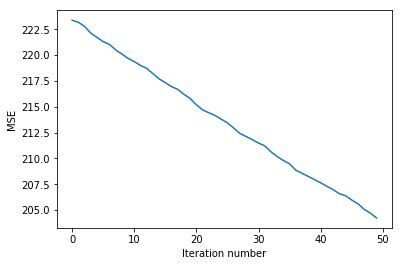

In [75]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[:50])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

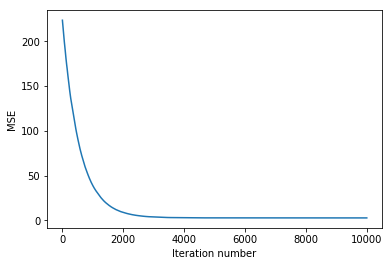

In [76]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

ПОЧЕМУ ЭТА ХЕРНЯ УХОДИТ В 400 И ОСТАНАВЛИВАЕТСЯ?

# Попытка в Momentum (ОСТАЛОСЬ ЧУТЬ - ЧУТЬ ДОПИЛИТЬ)

In [133]:
def backward(model, xs, hs, errs):
    """xs, hs, errs contain all informations (input, hidden state, error) of all data in the minibatch"""
    # errs is the gradients of output layer for the minibatch
    dW2 = hs.T @ errs

    # Get gradient of hidden layer
    dh = errs @ model['W2'].T
    dh[hs <= 0] = 0

    dW1 = xs.T @ dh

    return dict(W1=dW1, W2=dW2)


In [134]:
def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y = shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

In [135]:
def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)

        # Create probability distribution of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of minibatch
        # x: input
        # h: hidden state
        # err: gradient of output layer
        xs.append(x)
        hs.append(h)
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs), np.array(errs))

In [146]:
def momentum(model, X_train, y_train, minibatch_size):
    model.tolist()
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]

    return model

In [144]:
def sgd(model, X_train, y_train, minibatch_size):
    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            model[layer] += alpha * grad[layer]

    return model

In [147]:
model = momentum(np.zeros(4), X, y, 100)

ValueError: can only convert an array of size 1 to a Python scalar

# Применение алгоритмов (работает, довольно красиво, юзал tenserflow)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

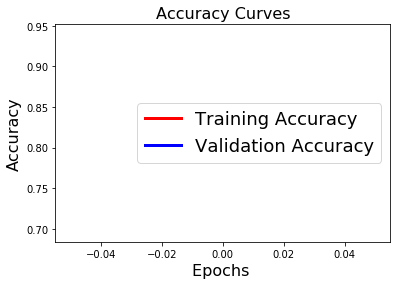

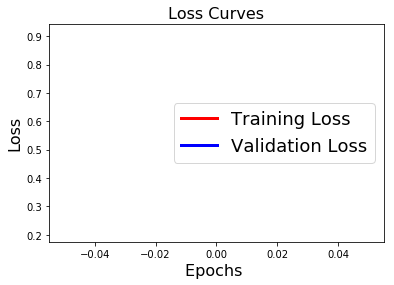

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [158]:
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.utils import np_utils
import os
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


def plot_loss_accuracy(history):
    plt.figure()
    epochs = range(len(history.epoch))
    plt.plot(epochs, history.history['acc'], 'r', linewidth=3.0)
    plt.plot(epochs,history.history['val_acc'], 'b', linewidth=3.0)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    
    plt.figure()
    plt.plot(epochs, history.history['loss'], 'r', linewidth=3.0)
    plt.plot(epochs,history.history['val_loss'], 'b', linewidth=3.0)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
    
    plt.show()

np.random.seed(100)

digit_train =  pd.read_csv("./train.csv")
digit_train.shape
#digit_train.info()

X_train = digit_train.iloc[:,1:].values.astype('float32')/255.0
##As we need images to be feeded to the CNN model , we are converting features to images
X_train_images=X_train.reshape(X_train.shape[0],28,28,1)

y_train = np_utils.to_categorical(digit_train["label"])

random_seed = 2
X_train_images, X_val, y_train, Y_val = train_test_split(X_train_images, y_train, test_size = 0.1, random_state=random_seed)

img_width, img_height = 28, 28

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape,padding = 'Same'))
model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10,  activation='softmax'))
print(model.summary())

model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_images)

epochs = 1 ## change this to 20
batchsize = 20
X_train_images.shape
# Fit the model
history = model.fit_generator(datagen.flow(X_train_images,y_train, batch_size=batchsize),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train_images.shape[0] // batchsize)

#history = model.fit(x=X_train_images, y=y_train, verbose=1, epochs=epochs, batch_size=batchsize, validation_split=0.2)
#print(model.get_weights())

historydf = pd.DataFrame(history.history, index=history.epoch)
plot_loss_accuracy(history)

digit_test = pd.read_csv("./test.csv")
digit_test.shape
digit_test.info()

X_test = digit_test.values.astype('float32')/255.0
X_test_images=X_test.reshape(X_test.shape[0],28,28,1)

pred = model.predict_classes(X_test_images)
submissions=pd.DataFrame({"ImageId": list(range(1,len(pred)+1)),
                         "Label": pred})
submissions.to_csv("submission.csv", index=False, header=True)